# For Creating Simple Training Data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

In [7]:
def save_pgm(image, filename, max_val=255):
    """
    Save an array to a PGM file.
    
    Parameters:
    - image: 2D numpy array of pixel values.
    - filename: String, the name of the file to save the image to.
    - max_val: Integer, the maximum pixel value (typically 255 for 8-bit images).
    """
    # Ensure the pixel values are within the correct range
    image = np.clip(image, 0, max_val)
    
    # Open the file for writing
    with open(filename, 'wb') as f:
        # Write the PGM header
        f.write(bytes(f"P5\n{image.shape[1]} {image.shape[0]}\n{max_val}\n", 'ascii'))
        
        # Write the pixel data
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        image.tofile(f)

In [8]:
def forward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,0:cols-2];
    d[:,0] = image[:,0] - image[:,cols-1];
    return d

def forward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1, :] = image[1:rows-1, :] - image[0:rows-2, :];
    d[0,:] = image[0,:] - image[rows-1,:];
    return d

def compute_gradient(image):
    #finds the gradient of each pixel in both x and y directions
    gradient_x = forward_difference_x(image)
    gradient_y = forward_difference_y(image)
    return gradient_x, gradient_y

def compute_divergence(gradient_x, gradient_y):
    #finds the divergence in each pixel
    div_x = -forward_difference_x(gradient_x)
    div_y = -forward_difference_y(gradient_y)
    return div_x + div_y

In [9]:
def convert_pgm_to_tiff(pgm_path, tiff_path):
    # Open the PGM file using Pillow
    with Image.open(pgm_path) as img:
        # Save the image as a TIFF file
        img.save(tiff_path, format='TIFF')

In [10]:
def find_center(elevation):
    gradient_x, gradient_y = compute_gradient(elevation)
    divergence = compute_divergence(gradient_x, gradient_y)
    
    # Find the point with the minimum divergence (assumed to be the center)
    center_idx = np.unravel_index(np.argmin(divergence), divergence.shape)
    return center_idx

def find_crater(elevation):
    gradient_x, gradient_y = compute_gradient(elevation)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Define crater as regions where the gradient magnitude is significantly above the threshold
    threshold = np.percentile(magnitude, 5)  # Adjust threshold as necessary
    rim = magnitude > threshold
    return rim

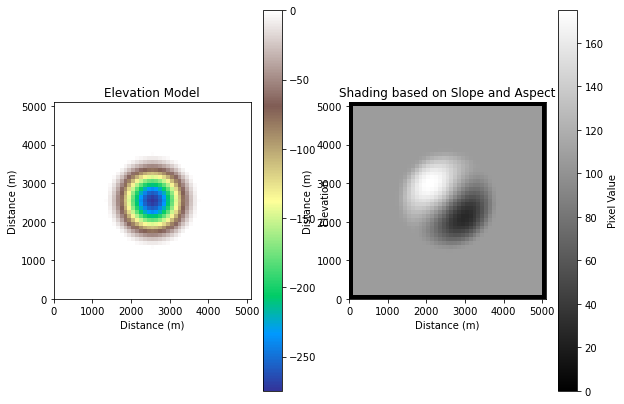

Image saved to RawPits/hole_mx51_my51_slope20_el25_az45_xrad1250_yrad1250.pgm
Label image saved to RawLabels/hole_mx51_my51_slope20_el25_az45_xrad1250_yrad1250.pgm


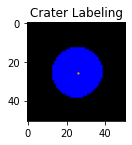

In [13]:
def make_hole(mx=51, my=51, pixel_size=100.0, max_slope_deg=20, sun_elevation_deg=25,
              sun_azimuth_deg=45,radius_x=None, radius_y=None, data_dir='.', label_dir = '.'):

    # Constants
    radian = np.pi / 180.0
    pi = np.pi

    # Set default radii if not specified
    if radius_x is None:
        radius_x = pixel_size * 0.25 * (mx - 1)
    if radius_y is None:
        radius_y = pixel_size * 0.25 * (my - 1)
    
    xmid = pixel_size * 0.5 * (mx - 1)
    ymid = pixel_size * 0.5 * (my - 1)
    max_slope = np.tan(radian * max_slope_deg)
    sun_elevation = radian * sun_elevation_deg
    sun_azimuth = radian * sun_azimuth_deg
    zenith = radian * 90

    # Allocate elevation array
    elevation = np.zeros((mx, my), dtype=np.float32)

    # Create an elliptical hole
    for j in range(my):
        y = j * pixel_size
        for i in range(mx):
            x = i * pixel_size
            # Elliptical distance calculation
            ellipse_dist = ((x - xmid) ** 2 / radius_x ** 2) + ((y - ymid) ** 2 / radius_y ** 2)
            if ellipse_dist <= 1.0:
                rad_radius = pi * np.sqrt(ellipse_dist) / 2.0
                elevation[i, j] -= pixel_size * (1.0 - np.cos((pi / 2.0 - rad_radius)) ** 2) / max_slope

    # Allocate pixel array
    pixel = np.zeros((mx, my), dtype=np.int32)

    # Calculate pixel values based on slope and aspect
    for j in range(1, my - 1):
        for i in range(1, mx - 1):
            aa, bb, cc = elevation[i-1, j-1:j+2]
            dd, ee, ff = elevation[i, j-1:j+2]
            gg, hh, ii = elevation[i+1, j-1:j+2]
            dzdx = (-(gg + 2.0 * hh + ii) + (aa + 2 * bb + cc)) / (8.0 * pixel_size)
            dzdy = (-(cc + 2.0 * ff + ii) + (aa + 2 * dd + gg)) / (8.0 * pixel_size)
            slope = np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2))
            aspect = np.arctan2(dzdy, dzdx)
            pixel[i, j] = int(255.0 * ((np.cos(zenith - sun_elevation) * np.cos(slope)) +
                                       (np.sin(zenith - sun_elevation) * np.sin(slope) * np.cos(sun_azimuth - aspect))))

    
    # Find the crater center and rim
    center = find_center(elevation)
    crater = find_crater(elevation)

    # Create a label image
    label_image = np.zeros((elevation.shape[0], elevation.shape[1], 3), dtype=np.uint8)
    label_image[crater] = [0, 0, 255]  # Blue
    label_image[center] = [255, 165, 0]  # Orange
    
    # Visualization
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.imshow(elevation, cmap='terrain', extent=[0, mx * pixel_size, 0, my * pixel_size])
    plt.colorbar(label='Elevation')
    plt.title('Elevation Model')
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')

    plt.subplot(1, 3, 2)
    plt.imshow(pixel, cmap='gray', extent=[0, mx * pixel_size, 0, my * pixel_size])
    plt.colorbar(label='Pixel Value')
    plt.title('Shading based on Slope and Aspect')
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')
    plt.show()

    plt.subplot(1, 3, 3)
    plt.imshow(label_image)
    plt.title('Crater Labeling')

    # Check if output directory exists, create if not
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    # Save the PGM image using PIL
    pgm_path = os.path.join(data_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}.pgm')
    image = Image.fromarray(pixel.astype('uint8'), 'L')
    image.save(pgm_path)
    convert_pgm_to_tiff(pgm_path, os.path.join(data_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}.tif'))
    print(f"Image saved to {pgm_path}")
    
    # Save the label image as PGM using PIL
    label_path = os.path.join(label_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}.pgm')
    label_pgm = Image.fromarray(label_image, 'RGB')
    label_pgm.save(label_path)
    convert_pgm_to_tiff(label_path, os.path.join(label_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}.tif'))
    print(f"Label image saved to {label_path}")

# Example usage
make_hole(data_dir='RawPits', label_dir = 'RawLabels')

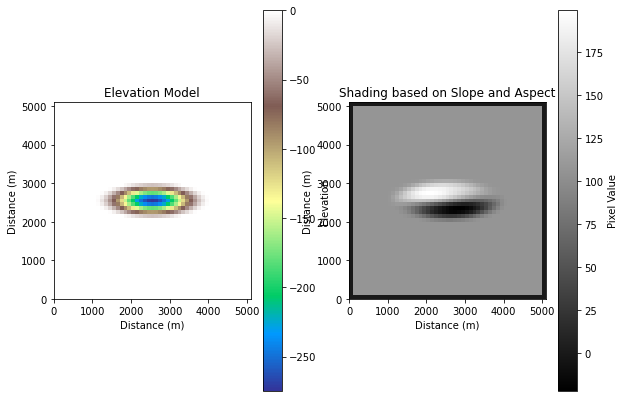

Image saved to RawPits/hole_mx51_my51_slope20_el25_az45_xrad500_yrad1500.pgm
Label image saved to RawLabels/hole_mx51_my51_slope20_el25_az45_xrad500_yrad1500.pgm


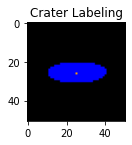

In [14]:
make_hole(radius_x = 500, radius_y = 1500, data_dir='RawPits', label_dir = 'RawLabels')

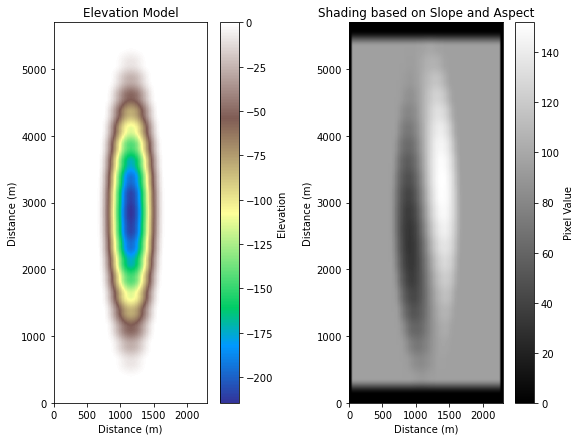

Image saved to RawPits/hole_mx23_my57_slope25_el22_az288_xrad1038_yrad1277.pgm
Label image saved to RawLabels/hole_mx23_my57_slope25_el22_az288_xrad1038_yrad1277.pgm


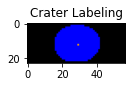

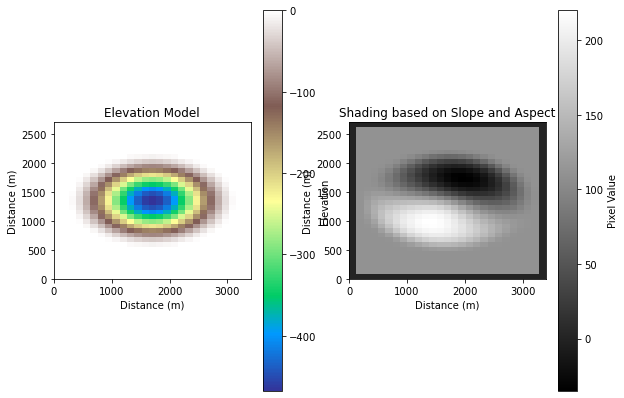

Image saved to RawPits/hole_mx34_my27_slope12_el26_az157_xrad1046_yrad1173.pgm
Label image saved to RawLabels/hole_mx34_my27_slope12_el26_az157_xrad1046_yrad1173.pgm


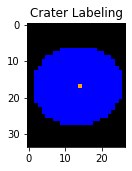

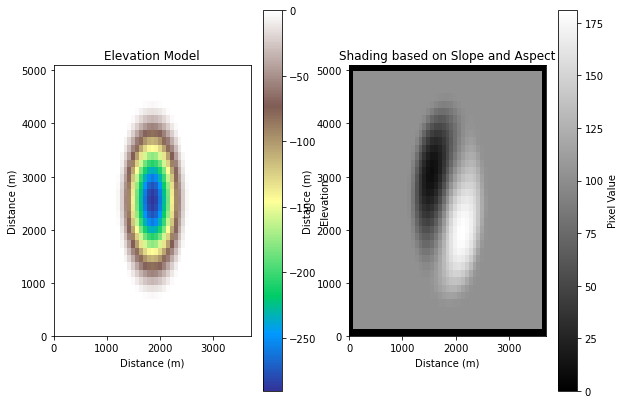

Image saved to RawPits/hole_mx37_my51_slope19_el24_az227_xrad1403_yrad975.pgm
Label image saved to RawLabels/hole_mx37_my51_slope19_el24_az227_xrad1403_yrad975.pgm


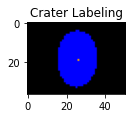

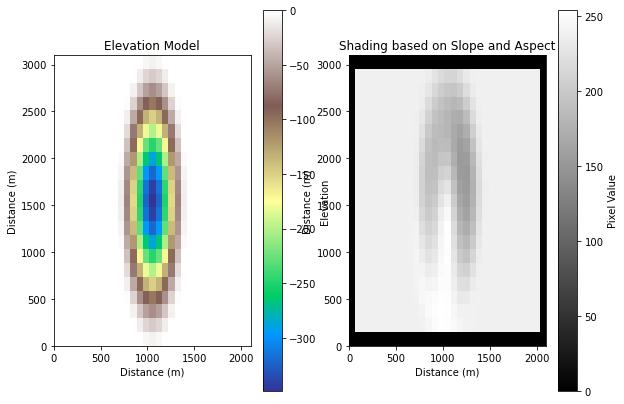

Image saved to RawPits/hole_mx21_my31_slope16_el70_az161_xrad1101_yrad560.pgm
Label image saved to RawLabels/hole_mx21_my31_slope16_el70_az161_xrad1101_yrad560.pgm


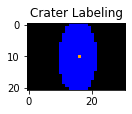

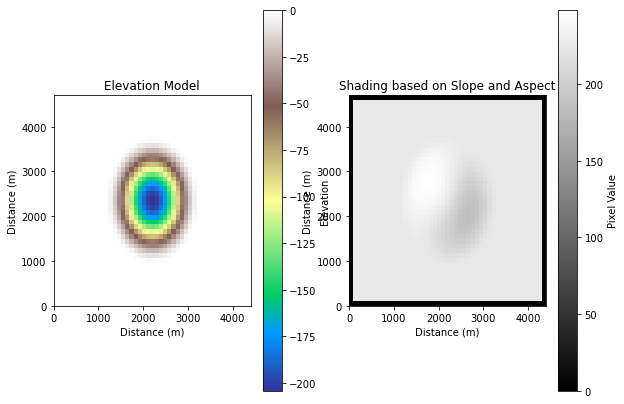

Image saved to RawPits/hole_mx44_my47_slope26_el62_az54_xrad1342_yrad1112.pgm
Label image saved to RawLabels/hole_mx44_my47_slope26_el62_az54_xrad1342_yrad1112.pgm


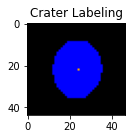

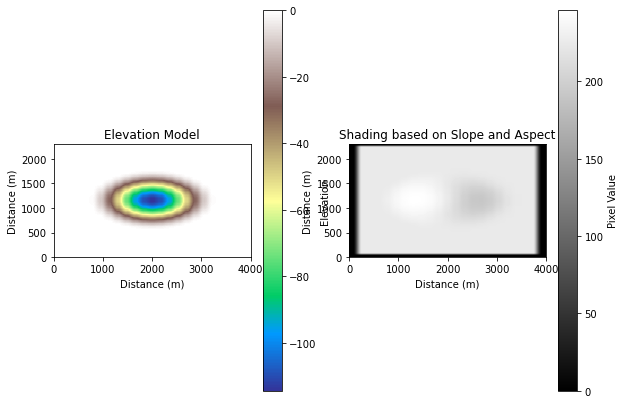

Image saved to RawPits/hole_mx40_my23_slope41_el62_az86_xrad1051_yrad739.pgm
Label image saved to RawLabels/hole_mx40_my23_slope41_el62_az86_xrad1051_yrad739.pgm


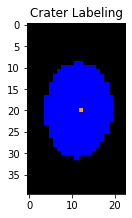

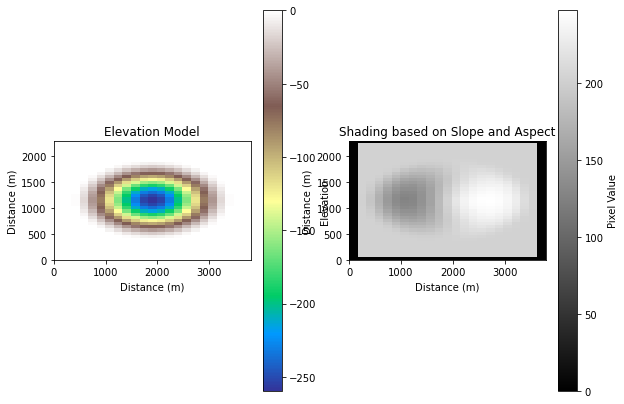

Image saved to RawPits/hole_mx38_my23_slope21_el53_az267_xrad1281_yrad950.pgm
Label image saved to RawLabels/hole_mx38_my23_slope21_el53_az267_xrad1281_yrad950.pgm


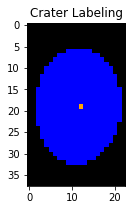

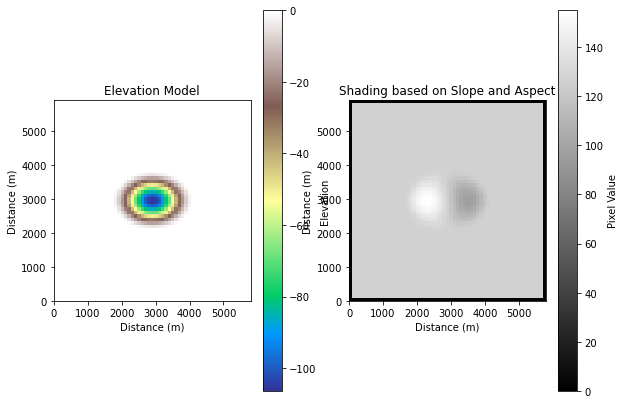

Image saved to RawPits/hole_mx58_my59_slope43_el30_az91_xrad866_yrad1224.pgm
Label image saved to RawLabels/hole_mx58_my59_slope43_el30_az91_xrad866_yrad1224.pgm


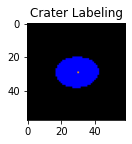

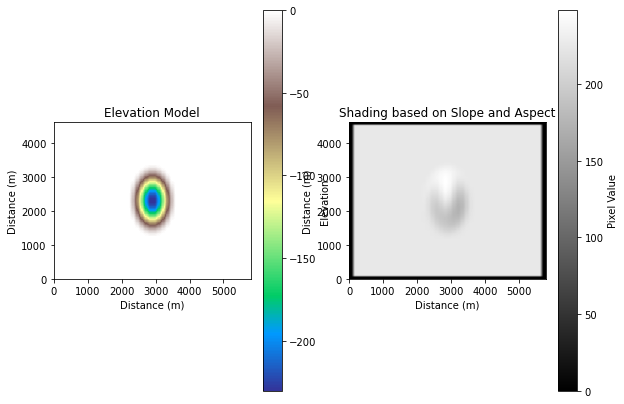

Image saved to RawPits/hole_mx58_my46_slope23_el62_az11_xrad1380_yrad567.pgm
Label image saved to RawLabels/hole_mx58_my46_slope23_el62_az11_xrad1380_yrad567.pgm


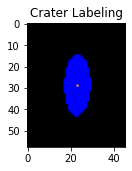

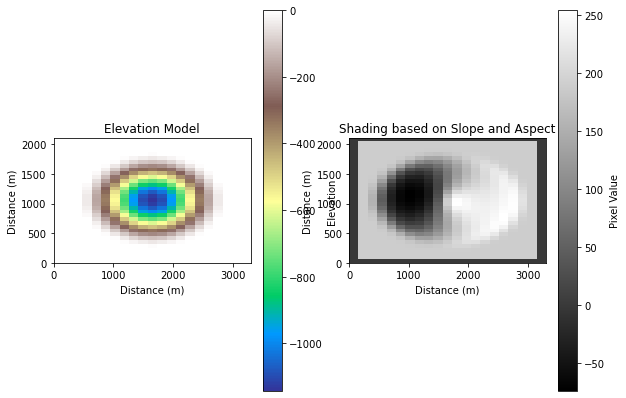

Image saved to RawPits/hole_mx33_my21_slope5_el48_az257_xrad1251_yrad794.pgm
Label image saved to RawLabels/hole_mx33_my21_slope5_el48_az257_xrad1251_yrad794.pgm


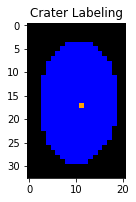

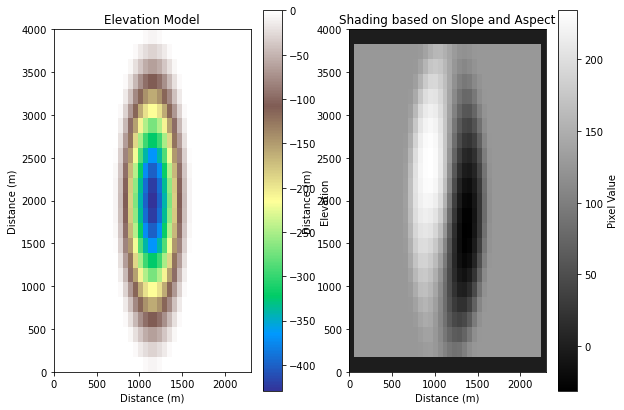

Image saved to RawPits/hole_mx23_my40_slope13_el30_az65_xrad1203_yrad822.pgm
Label image saved to RawLabels/hole_mx23_my40_slope13_el30_az65_xrad1203_yrad822.pgm


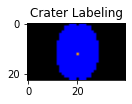

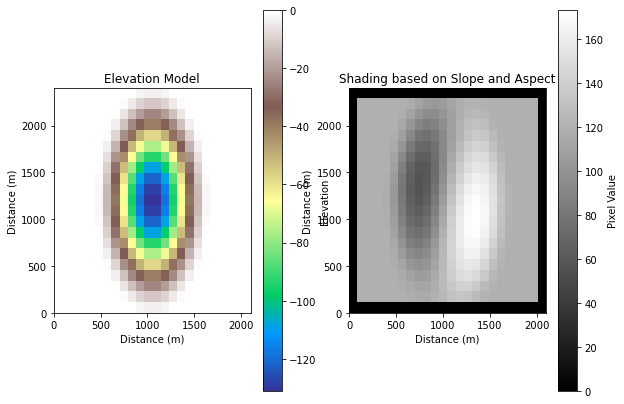

Image saved to RawPits/hole_mx21_my24_slope37_el28_az245_xrad1117_yrad702.pgm
Label image saved to RawLabels/hole_mx21_my24_slope37_el28_az245_xrad1117_yrad702.pgm


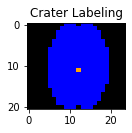

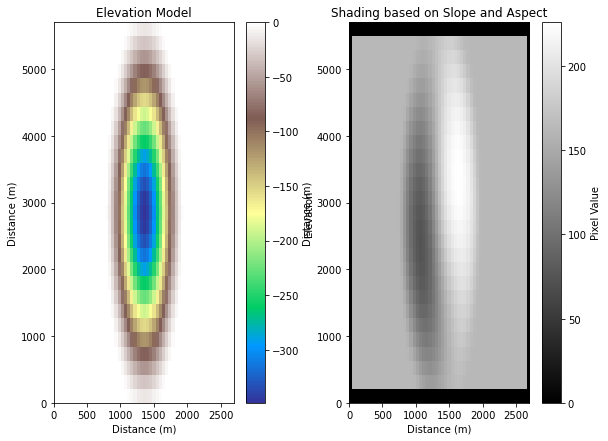

Image saved to RawPits/hole_mx27_my57_slope16_el40_az291_xrad1493_yrad1252.pgm
Label image saved to RawLabels/hole_mx27_my57_slope16_el40_az291_xrad1493_yrad1252.pgm


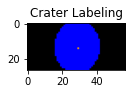

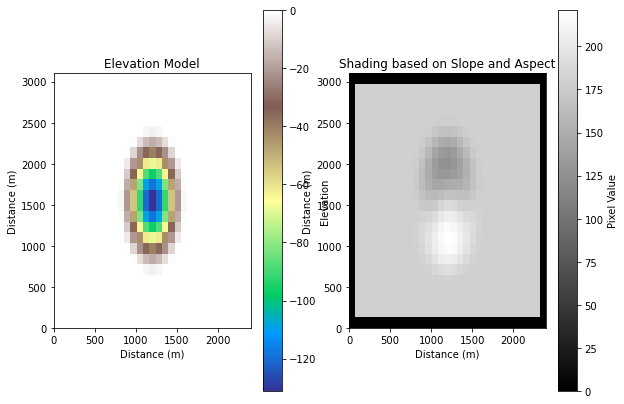

Image saved to RawPits/hole_mx24_my31_slope37_el45_az183_xrad715_yrad541.pgm
Label image saved to RawLabels/hole_mx24_my31_slope37_el45_az183_xrad715_yrad541.pgm


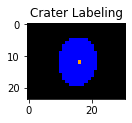

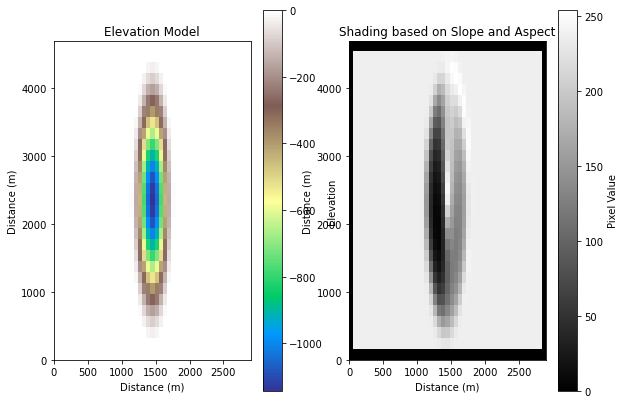

Image saved to RawPits/hole_mx29_my47_slope5_el69_az314_xrad1336_yrad524.pgm
Label image saved to RawLabels/hole_mx29_my47_slope5_el69_az314_xrad1336_yrad524.pgm


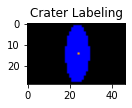

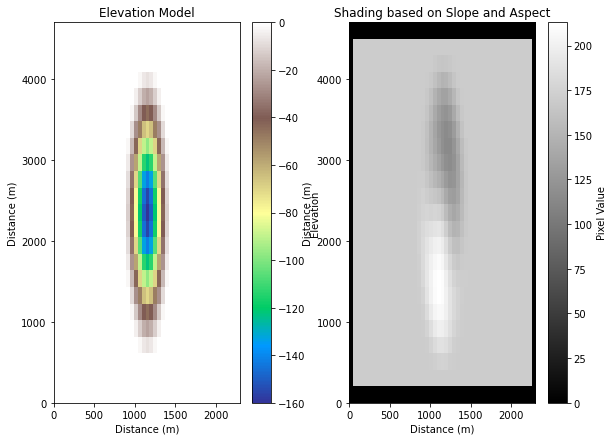

Image saved to RawPits/hole_mx23_my47_slope32_el42_az164_xrad930_yrad608.pgm
Label image saved to RawLabels/hole_mx23_my47_slope32_el42_az164_xrad930_yrad608.pgm


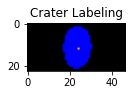

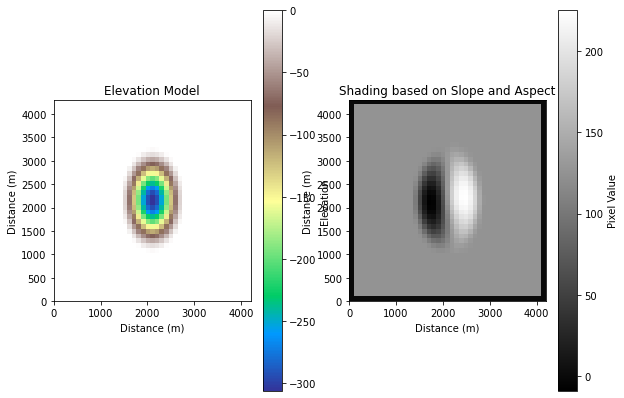

Image saved to RawPits/hole_mx42_my43_slope18_el30_az279_xrad1117_yrad724.pgm
Label image saved to RawLabels/hole_mx42_my43_slope18_el30_az279_xrad1117_yrad724.pgm


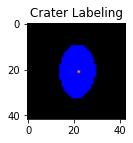

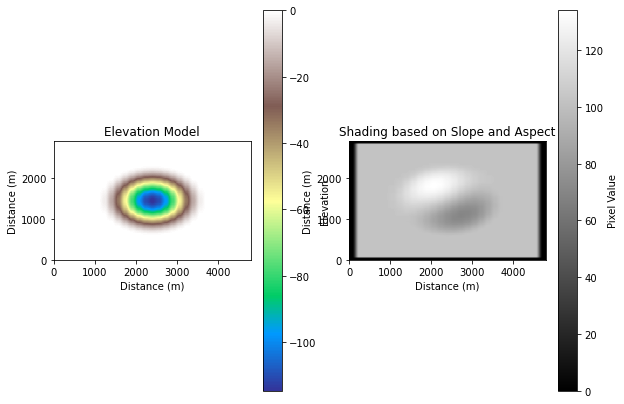

Image saved to RawPits/hole_mx48_my29_slope41_el24_az20_xrad1429_yrad786.pgm
Label image saved to RawLabels/hole_mx48_my29_slope41_el24_az20_xrad1429_yrad786.pgm


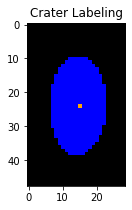

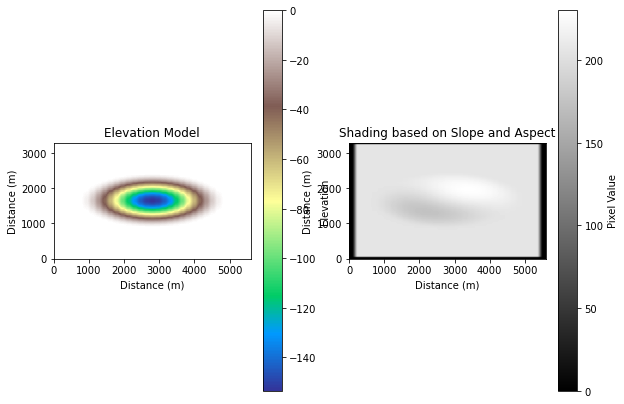

Image saved to RawPits/hole_mx56_my33_slope33_el54_az326_xrad1308_yrad1225.pgm
Label image saved to RawLabels/hole_mx56_my33_slope33_el54_az326_xrad1308_yrad1225.pgm


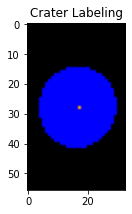

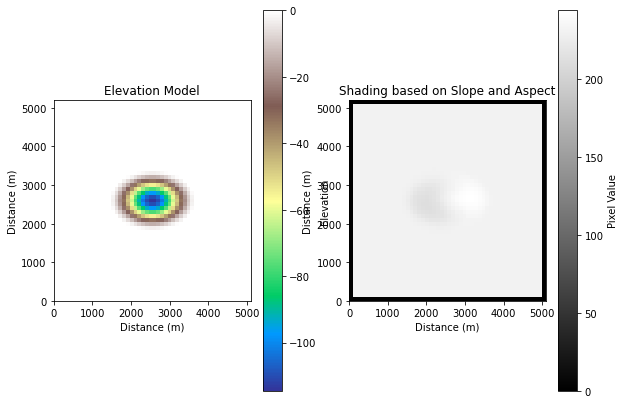

Image saved to RawPits/hole_mx51_my52_slope41_el65_az278_xrad778_yrad1171.pgm
Label image saved to RawLabels/hole_mx51_my52_slope41_el65_az278_xrad778_yrad1171.pgm


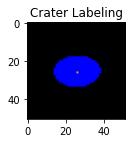

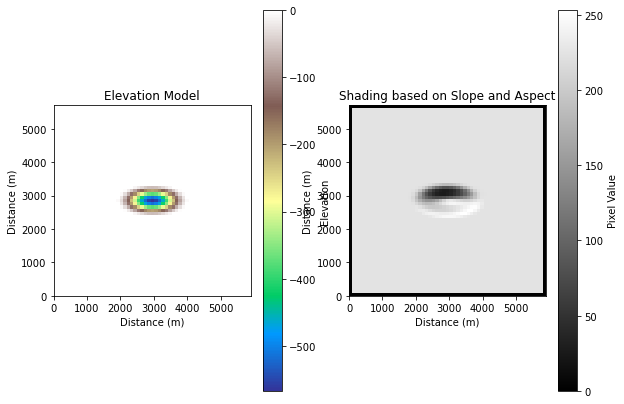

Image saved to RawPits/hole_mx59_my57_slope10_el62_az205_xrad506_yrad1063.pgm
Label image saved to RawLabels/hole_mx59_my57_slope10_el62_az205_xrad506_yrad1063.pgm


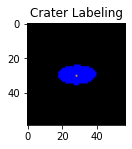

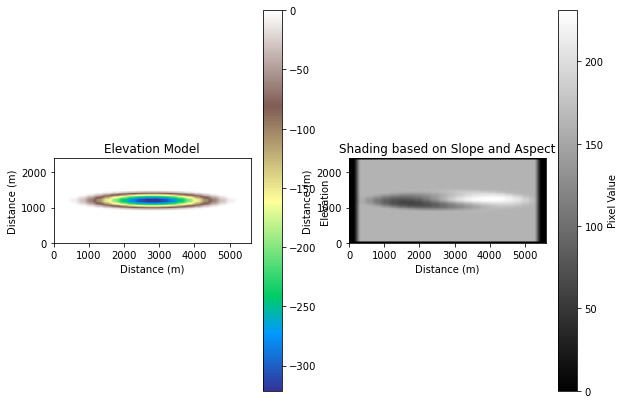

Image saved to RawPits/hole_mx56_my24_slope17_el40_az286_xrad712_yrad1059.pgm
Label image saved to RawLabels/hole_mx56_my24_slope17_el40_az286_xrad712_yrad1059.pgm


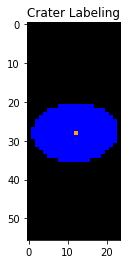

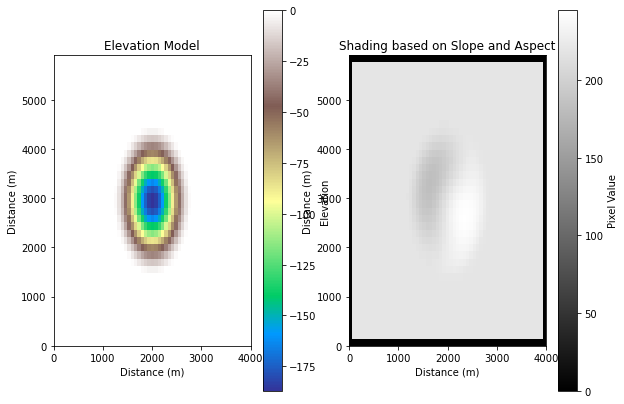

Image saved to RawPits/hole_mx40_my59_slope28_el60_az246_xrad1049_yrad1170.pgm
Label image saved to RawLabels/hole_mx40_my59_slope28_el60_az246_xrad1049_yrad1170.pgm


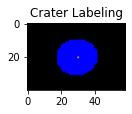

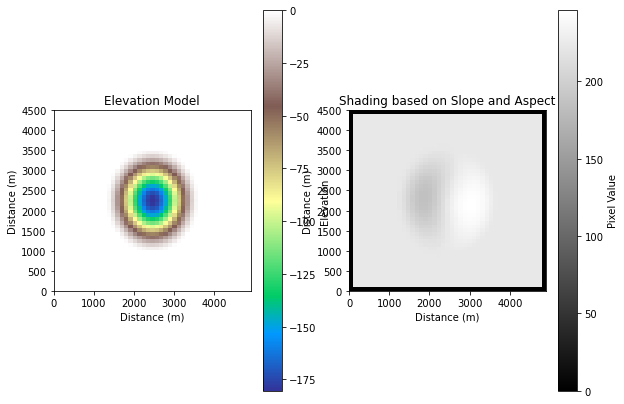

Image saved to RawPits/hole_mx49_my45_slope29_el61_az260_xrad1452_yrad1089.pgm
Label image saved to RawLabels/hole_mx49_my45_slope29_el61_az260_xrad1452_yrad1089.pgm


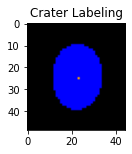

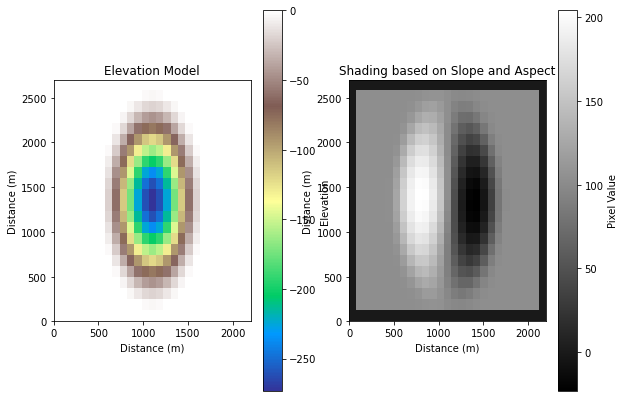

Image saved to RawPits/hole_mx22_my27_slope20_el24_az86_xrad1023_yrad726.pgm
Label image saved to RawLabels/hole_mx22_my27_slope20_el24_az86_xrad1023_yrad726.pgm


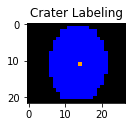

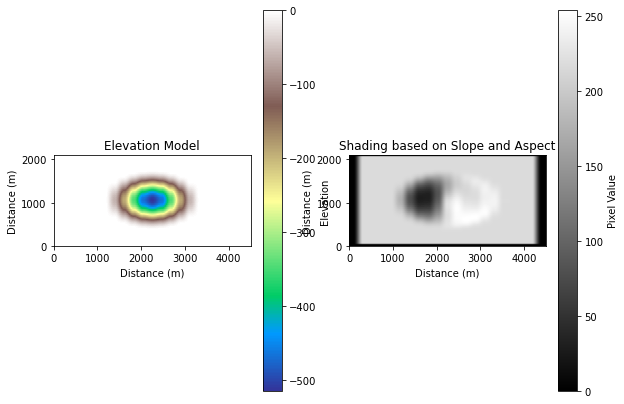

Image saved to RawPits/hole_mx45_my21_slope11_el59_az243_xrad1472_yrad514.pgm
Label image saved to RawLabels/hole_mx45_my21_slope11_el59_az243_xrad1472_yrad514.pgm


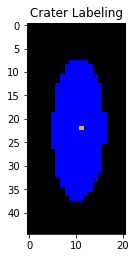

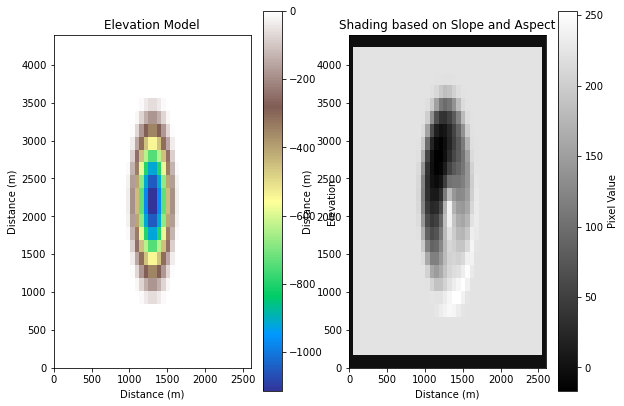

Image saved to RawPits/hole_mx26_my44_slope5_el61_az211_xrad884_yrad616.pgm
Label image saved to RawLabels/hole_mx26_my44_slope5_el61_az211_xrad884_yrad616.pgm


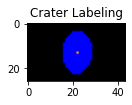

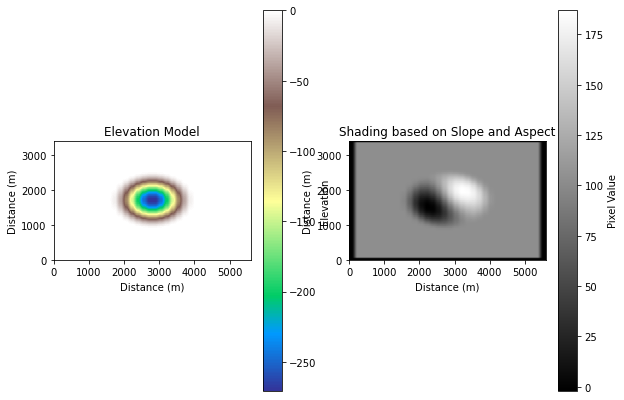

Image saved to RawPits/hole_mx56_my34_slope20_el24_az315_xrad1346_yrad725.pgm
Label image saved to RawLabels/hole_mx56_my34_slope20_el24_az315_xrad1346_yrad725.pgm


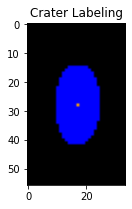

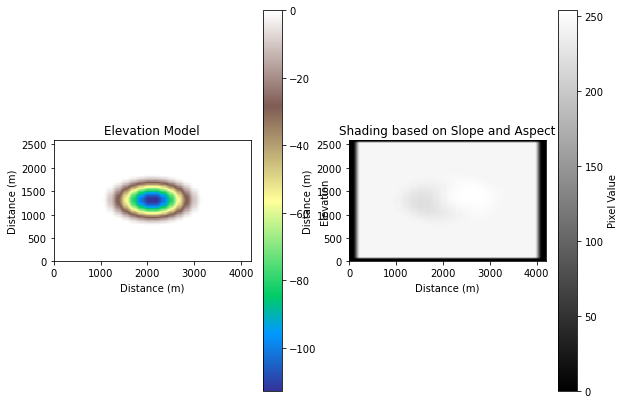

Image saved to RawPits/hole_mx42_my26_slope41_el74_az290_xrad906_yrad681.pgm
Label image saved to RawLabels/hole_mx42_my26_slope41_el74_az290_xrad906_yrad681.pgm


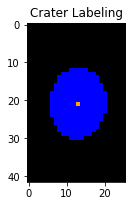

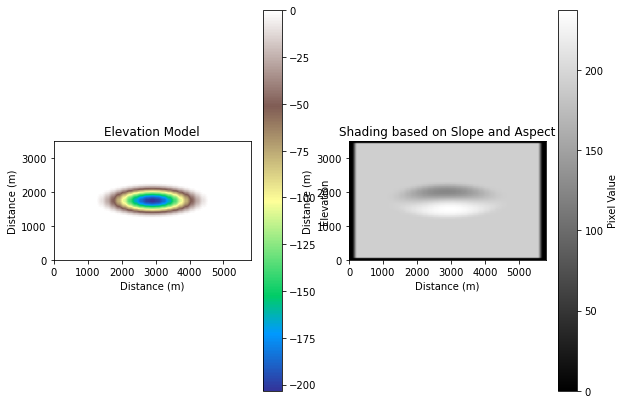

Image saved to RawPits/hole_mx58_my35_slope26_el49_az185_xrad868_yrad1041.pgm
Label image saved to RawLabels/hole_mx58_my35_slope26_el49_az185_xrad868_yrad1041.pgm


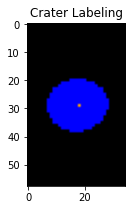

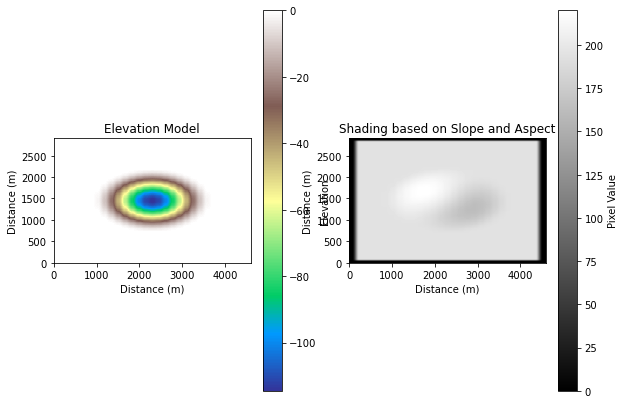

Image saved to RawPits/hole_mx46_my29_slope41_el50_az49_xrad1187_yrad872.pgm
Label image saved to RawLabels/hole_mx46_my29_slope41_el50_az49_xrad1187_yrad872.pgm


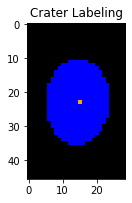

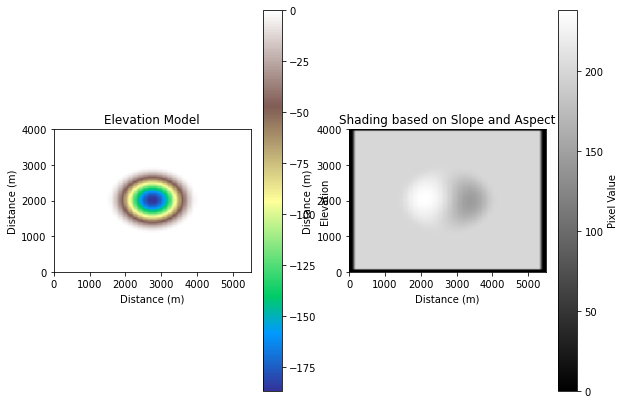

Image saved to RawPits/hole_mx55_my40_slope28_el52_az83_xrad1284_yrad924.pgm
Label image saved to RawLabels/hole_mx55_my40_slope28_el52_az83_xrad1284_yrad924.pgm


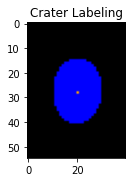

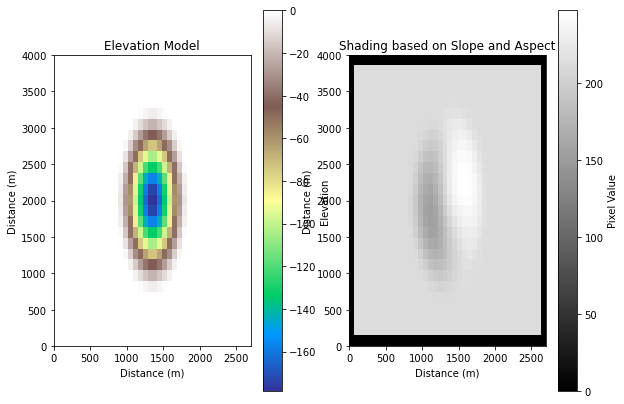

Image saved to RawPits/hole_mx27_my40_slope29_el57_az294_xrad899_yrad744.pgm
Label image saved to RawLabels/hole_mx27_my40_slope29_el57_az294_xrad899_yrad744.pgm


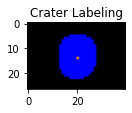

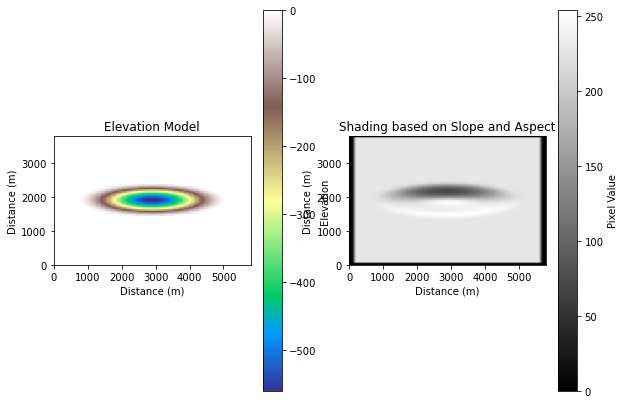

Image saved to RawPits/hole_mx58_my38_slope10_el64_az185_xrad782_yrad1459.pgm
Label image saved to RawLabels/hole_mx58_my38_slope10_el64_az185_xrad782_yrad1459.pgm


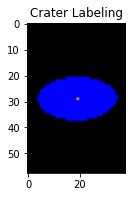

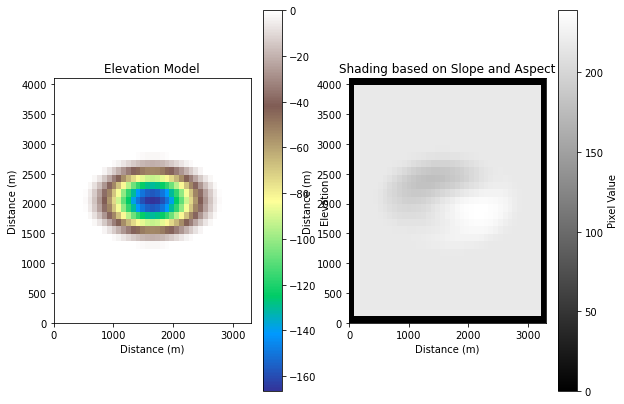

Image saved to RawPits/hole_mx33_my41_slope31_el59_az245_xrad647_yrad1495.pgm
Label image saved to RawLabels/hole_mx33_my41_slope31_el59_az245_xrad647_yrad1495.pgm


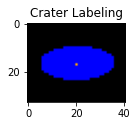

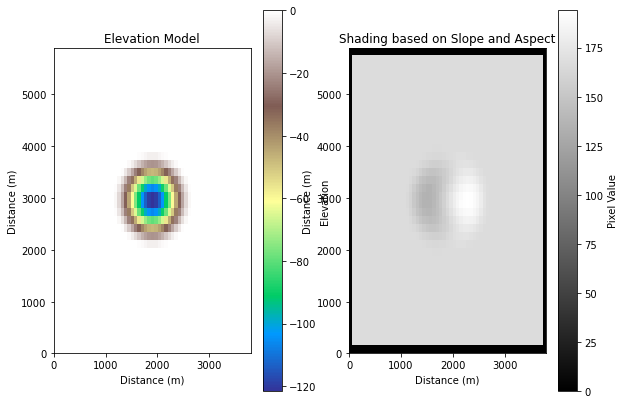

Image saved to RawPits/hole_mx38_my59_slope39_el41_az269_xrad612_yrad1195.pgm
Label image saved to RawLabels/hole_mx38_my59_slope39_el41_az269_xrad612_yrad1195.pgm


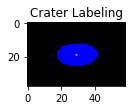

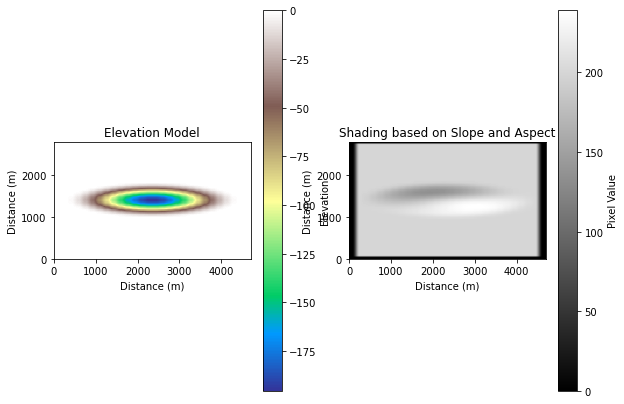

Image saved to RawPits/hole_mx47_my28_slope27_el52_az222_xrad702_yrad1229.pgm
Label image saved to RawLabels/hole_mx47_my28_slope27_el52_az222_xrad702_yrad1229.pgm


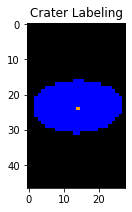

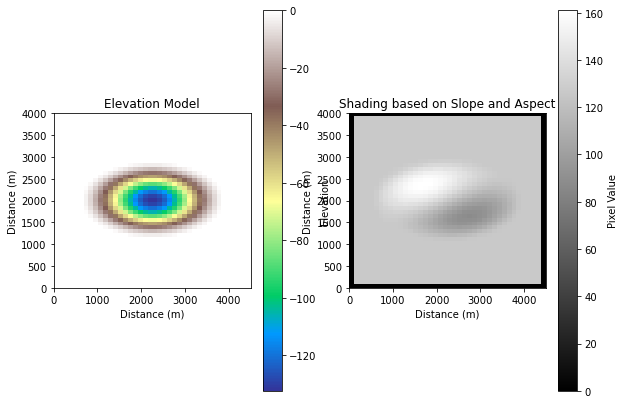

Image saved to RawPits/hole_mx45_my40_slope37_el30_az49_xrad1014_yrad1495.pgm
Label image saved to RawLabels/hole_mx45_my40_slope37_el30_az49_xrad1014_yrad1495.pgm


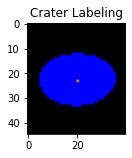

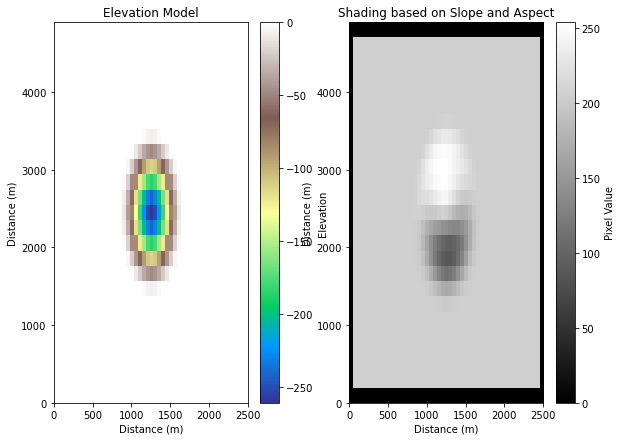

Image saved to RawPits/hole_mx25_my49_slope21_el54_az12_xrad555_yrad804.pgm
Label image saved to RawLabels/hole_mx25_my49_slope21_el54_az12_xrad555_yrad804.pgm


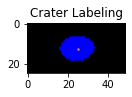

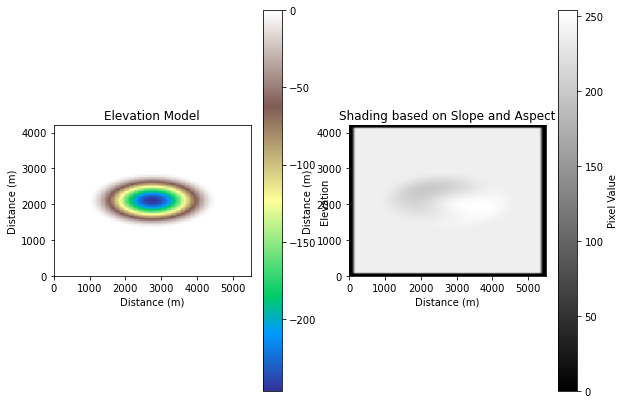

Image saved to RawPits/hole_mx55_my42_slope22_el69_az241_xrad1013_yrad1385.pgm
Label image saved to RawLabels/hole_mx55_my42_slope22_el69_az241_xrad1013_yrad1385.pgm


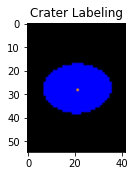

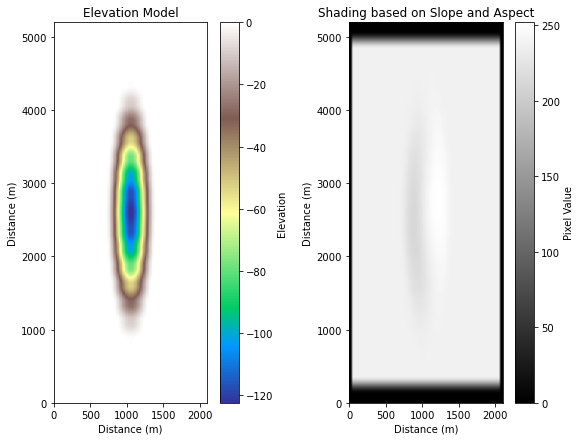

Image saved to RawPits/hole_mx21_my52_slope39_el69_az280_xrad733_yrad841.pgm
Label image saved to RawLabels/hole_mx21_my52_slope39_el69_az280_xrad733_yrad841.pgm


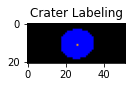

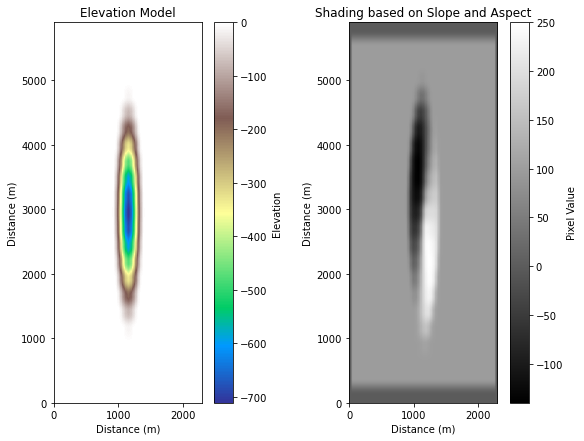

Image saved to RawPits/hole_mx23_my59_slope8_el23_az226_xrad766_yrad630.pgm
Label image saved to RawLabels/hole_mx23_my59_slope8_el23_az226_xrad766_yrad630.pgm


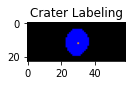

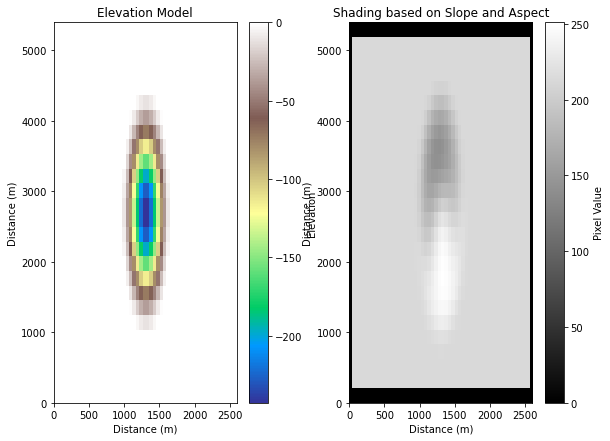

Image saved to RawPits/hole_mx26_my54_slope22_el57_az191_xrad871_yrad745.pgm
Label image saved to RawLabels/hole_mx26_my54_slope22_el57_az191_xrad871_yrad745.pgm


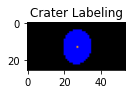

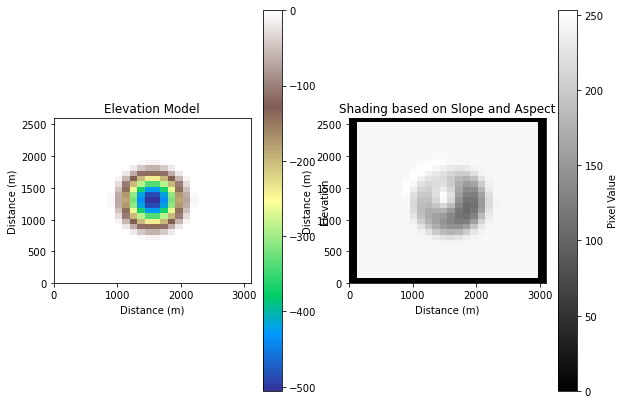

Image saved to RawPits/hole_mx31_my26_slope11_el74_az44_xrad776_yrad592.pgm
Label image saved to RawLabels/hole_mx31_my26_slope11_el74_az44_xrad776_yrad592.pgm


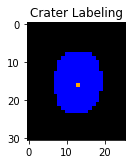

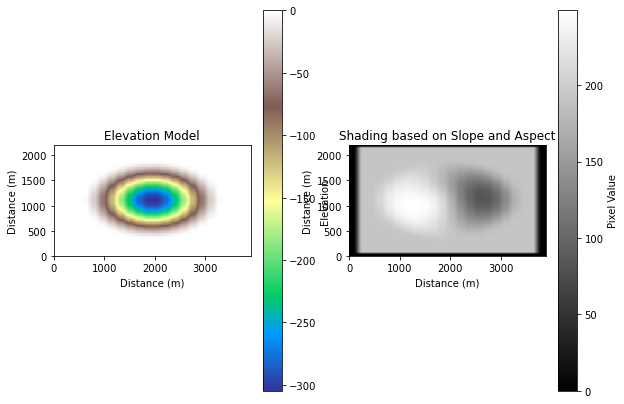

Image saved to RawPits/hole_mx39_my22_slope18_el49_az106_xrad1396_yrad790.pgm
Label image saved to RawLabels/hole_mx39_my22_slope18_el49_az106_xrad1396_yrad790.pgm


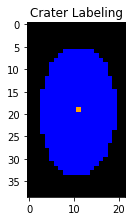

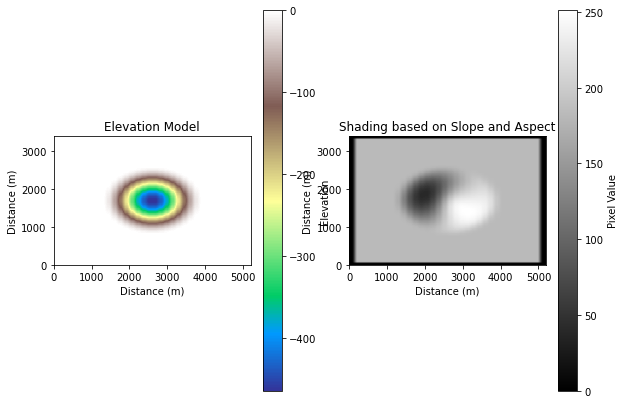

Image saved to RawPits/hole_mx52_my34_slope12_el46_az237_xrad1381_yrad858.pgm
Label image saved to RawLabels/hole_mx52_my34_slope12_el46_az237_xrad1381_yrad858.pgm


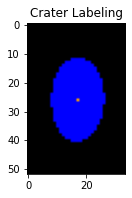

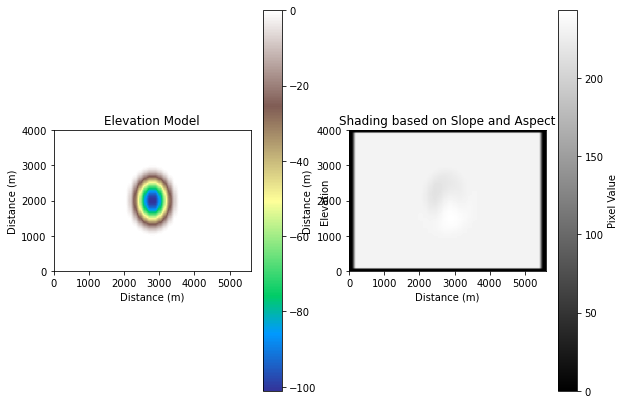

Image saved to RawPits/hole_mx56_my40_slope44_el66_az193_xrad1427_yrad544.pgm
Label image saved to RawLabels/hole_mx56_my40_slope44_el66_az193_xrad1427_yrad544.pgm


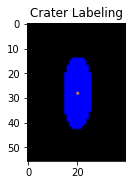

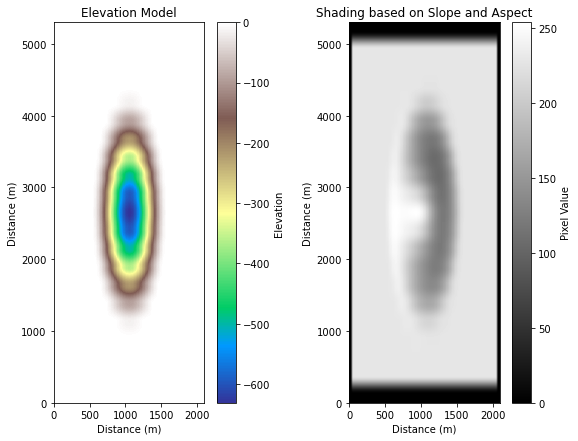

Image saved to RawPits/hole_mx21_my53_slope9_el64_az96_xrad666_yrad1332.pgm
Label image saved to RawLabels/hole_mx21_my53_slope9_el64_az96_xrad666_yrad1332.pgm


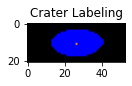

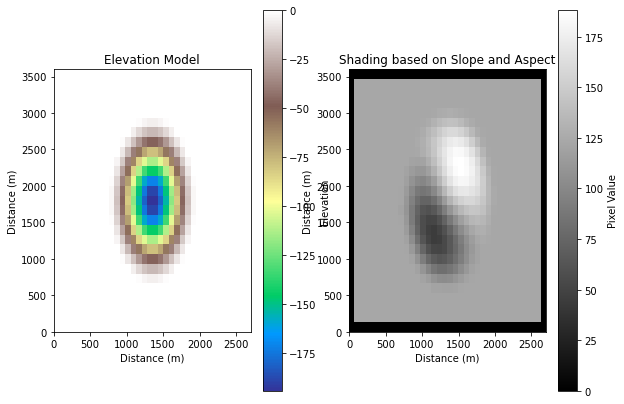

Image saved to RawPits/hole_mx27_my36_slope27_el29_az326_xrad892_yrad812.pgm
Label image saved to RawLabels/hole_mx27_my36_slope27_el29_az326_xrad892_yrad812.pgm


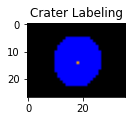

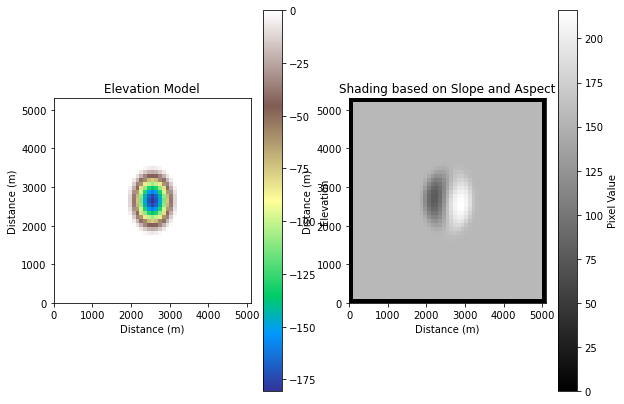

Image saved to RawPits/hole_mx51_my53_slope29_el38_az258_xrad911_yrad718.pgm
Label image saved to RawLabels/hole_mx51_my53_slope29_el38_az258_xrad911_yrad718.pgm


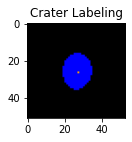

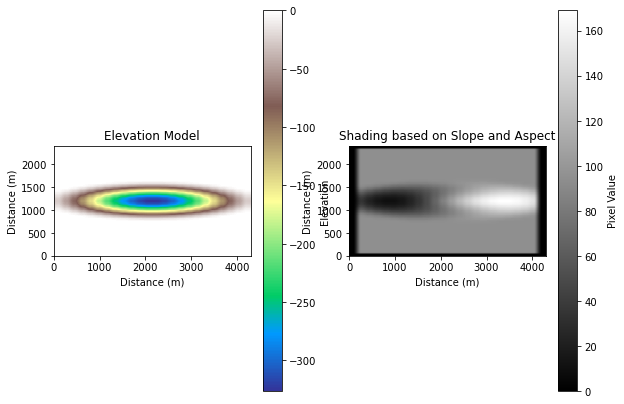

Image saved to RawPits/hole_mx43_my24_slope17_el22_az270_xrad803_yrad1405.pgm
Label image saved to RawLabels/hole_mx43_my24_slope17_el22_az270_xrad803_yrad1405.pgm


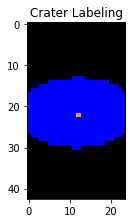

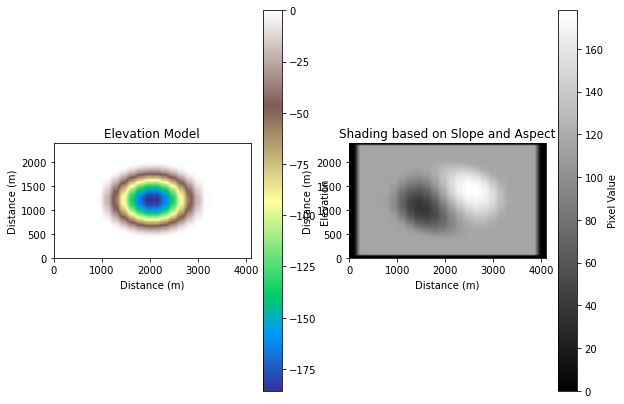

Image saved to RawPits/hole_mx41_my24_slope28_el27_az311_xrad1392_yrad699.pgm
Label image saved to RawLabels/hole_mx41_my24_slope28_el27_az311_xrad1392_yrad699.pgm


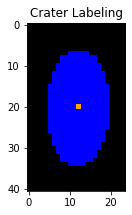

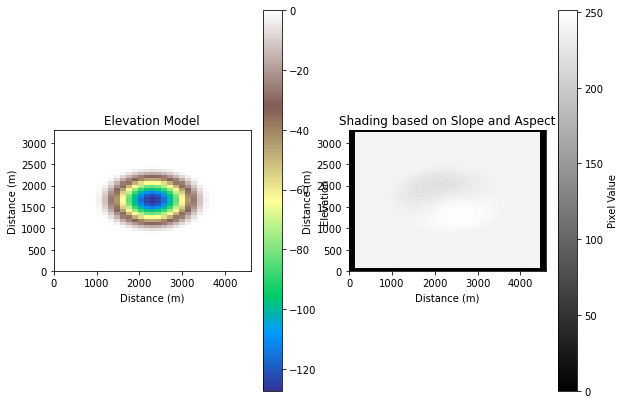

Image saved to RawPits/hole_mx46_my33_slope38_el70_az204_xrad1109_yrad998.pgm
Label image saved to RawLabels/hole_mx46_my33_slope38_el70_az204_xrad1109_yrad998.pgm


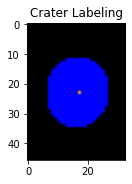

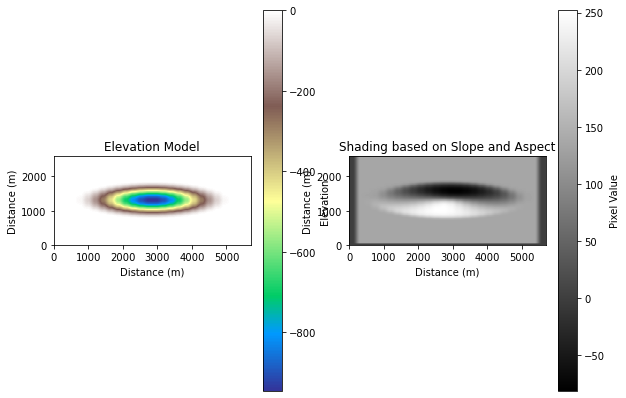

Image saved to RawPits/hole_mx57_my26_slope6_el32_az170_xrad1196_yrad1025.pgm
Label image saved to RawLabels/hole_mx57_my26_slope6_el32_az170_xrad1196_yrad1025.pgm


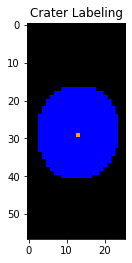

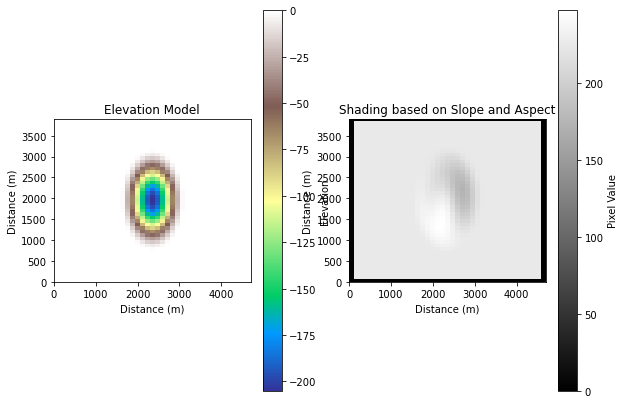

Image saved to RawPits/hole_mx47_my39_slope26_el62_az152_xrad1474_yrad644.pgm
Label image saved to RawLabels/hole_mx47_my39_slope26_el62_az152_xrad1474_yrad644.pgm


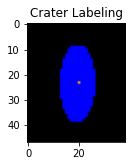

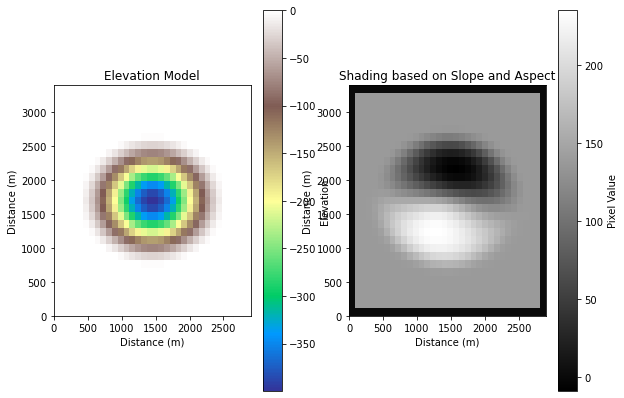

Image saved to RawPits/hole_mx29_my34_slope14_el33_az162_xrad843_yrad1297.pgm
Label image saved to RawLabels/hole_mx29_my34_slope14_el33_az162_xrad843_yrad1297.pgm


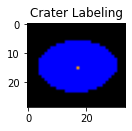

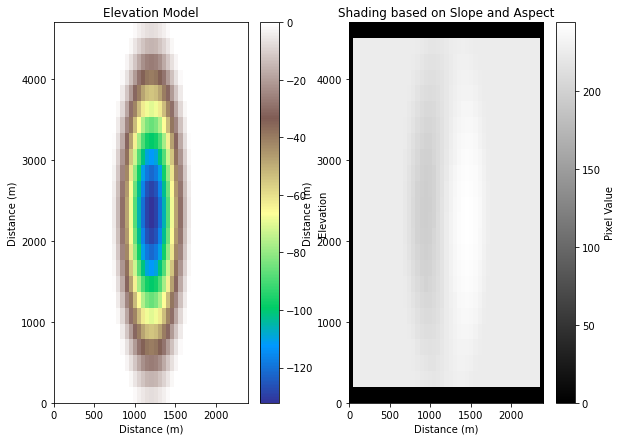

Image saved to RawPits/hole_mx24_my47_slope37_el62_az265_xrad1349_yrad1017.pgm
Label image saved to RawLabels/hole_mx24_my47_slope37_el62_az265_xrad1349_yrad1017.pgm


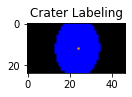

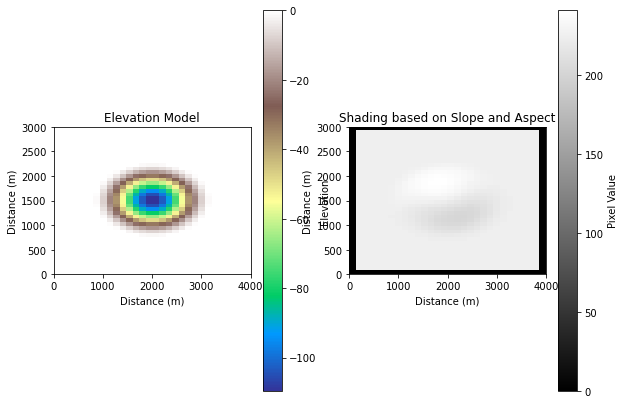

Image saved to RawPits/hole_mx40_my30_slope42_el62_az19_xrad1025_yrad909.pgm
Label image saved to RawLabels/hole_mx40_my30_slope42_el62_az19_xrad1025_yrad909.pgm


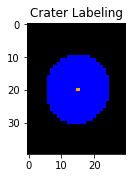

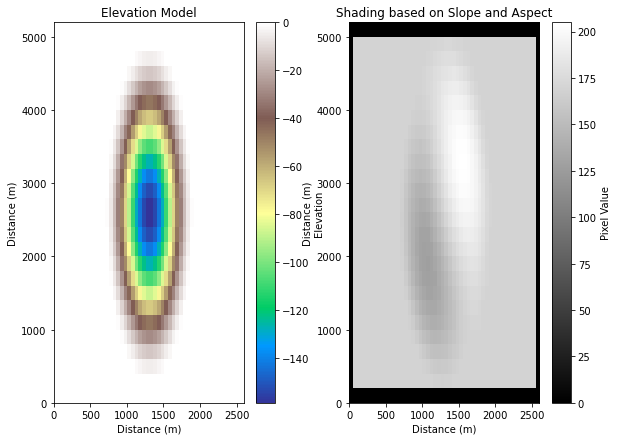

Image saved to RawPits/hole_mx26_my52_slope32_el42_az307_xrad1177_yrad1200.pgm
Label image saved to RawLabels/hole_mx26_my52_slope32_el42_az307_xrad1177_yrad1200.pgm


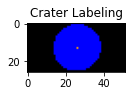

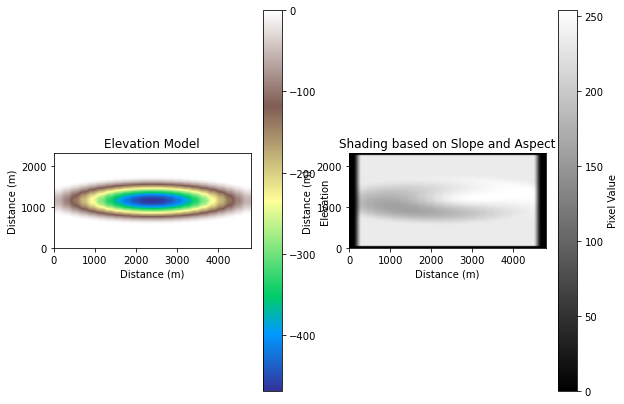

Image saved to RawPits/hole_mx48_my23_slope12_el67_az298_xrad1226_yrad1410.pgm
Label image saved to RawLabels/hole_mx48_my23_slope12_el67_az298_xrad1226_yrad1410.pgm


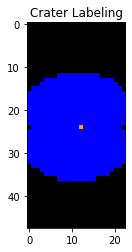

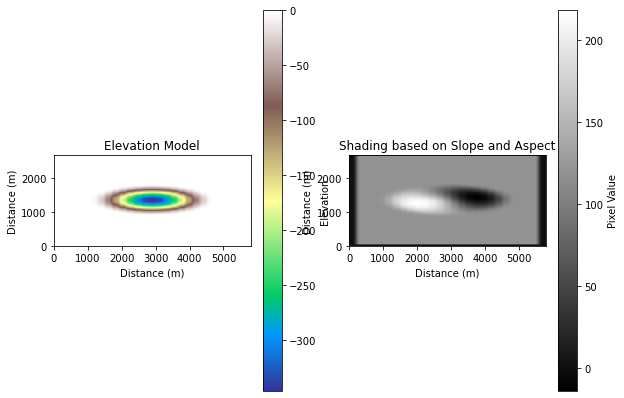

Image saved to RawPits/hole_mx58_my27_slope16_el28_az114_xrad994_yrad851.pgm
Label image saved to RawLabels/hole_mx58_my27_slope16_el28_az114_xrad994_yrad851.pgm


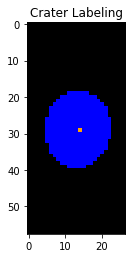

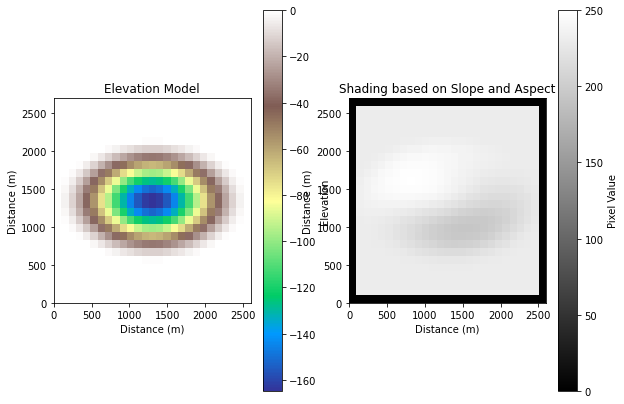

Image saved to RawPits/hole_mx26_my27_slope31_el65_az46_xrad787_yrad1325.pgm
Label image saved to RawLabels/hole_mx26_my27_slope31_el65_az46_xrad787_yrad1325.pgm


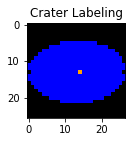

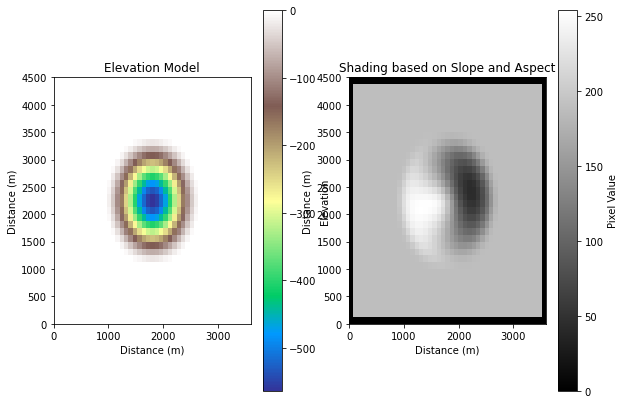

Image saved to RawPits/hole_mx36_my45_slope10_el48_az104_xrad975_yrad1110.pgm
Label image saved to RawLabels/hole_mx36_my45_slope10_el48_az104_xrad975_yrad1110.pgm


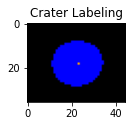

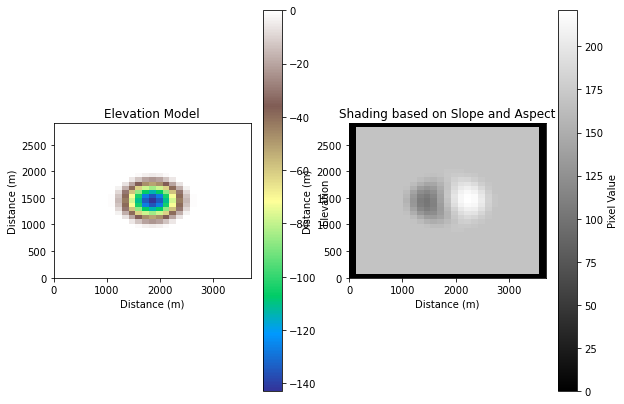

Image saved to RawPits/hole_mx37_my29_slope35_el42_az277_xrad678_yrad634.pgm
Label image saved to RawLabels/hole_mx37_my29_slope35_el42_az277_xrad678_yrad634.pgm


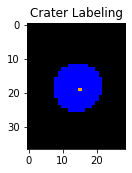

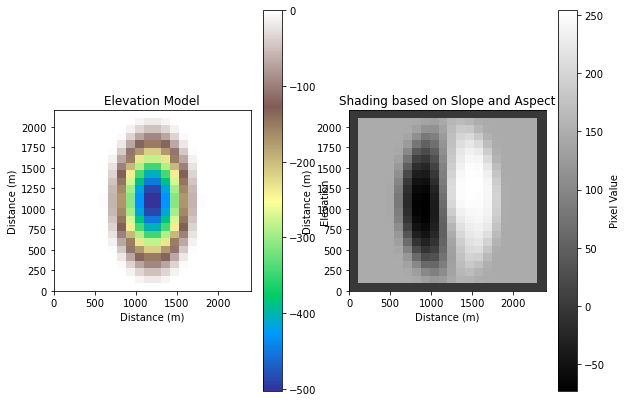

Image saved to RawPits/hole_mx24_my22_slope11_el35_az282_xrad1189_yrad577.pgm
Label image saved to RawLabels/hole_mx24_my22_slope11_el35_az282_xrad1189_yrad577.pgm


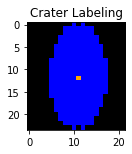

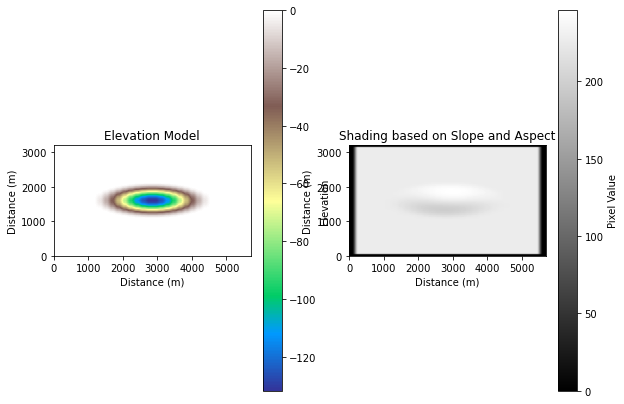

Image saved to RawPits/hole_mx57_my32_slope37_el63_az351_xrad931_yrad973.pgm
Label image saved to RawLabels/hole_mx57_my32_slope37_el63_az351_xrad931_yrad973.pgm


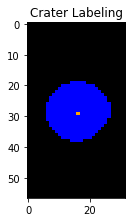

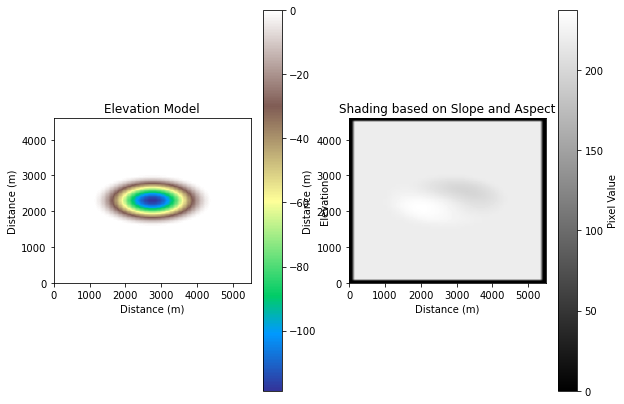

Image saved to RawPits/hole_mx55_my46_slope40_el60_az121_xrad862_yrad1409.pgm
Label image saved to RawLabels/hole_mx55_my46_slope40_el60_az121_xrad862_yrad1409.pgm


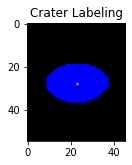

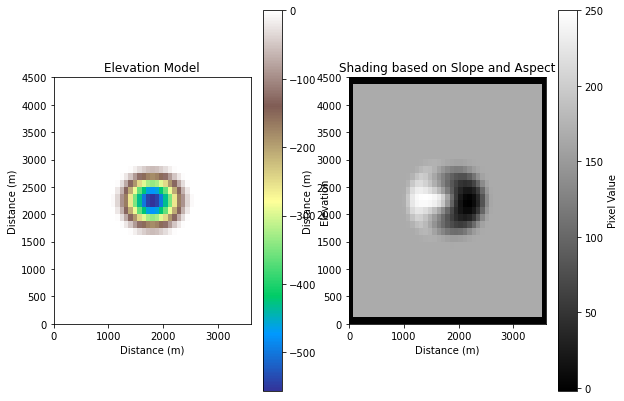

Image saved to RawPits/hole_mx36_my45_slope10_el41_az86_xrad566_yrad958.pgm
Label image saved to RawLabels/hole_mx36_my45_slope10_el41_az86_xrad566_yrad958.pgm


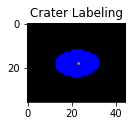

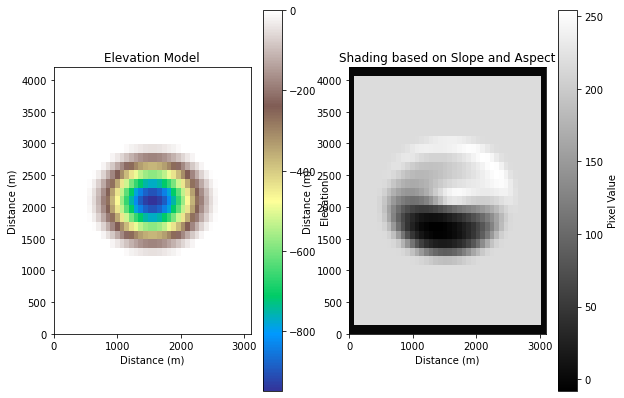

Image saved to RawPits/hole_mx31_my42_slope6_el59_az329_xrad700_yrad1477.pgm
Label image saved to RawLabels/hole_mx31_my42_slope6_el59_az329_xrad700_yrad1477.pgm


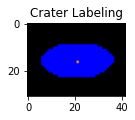

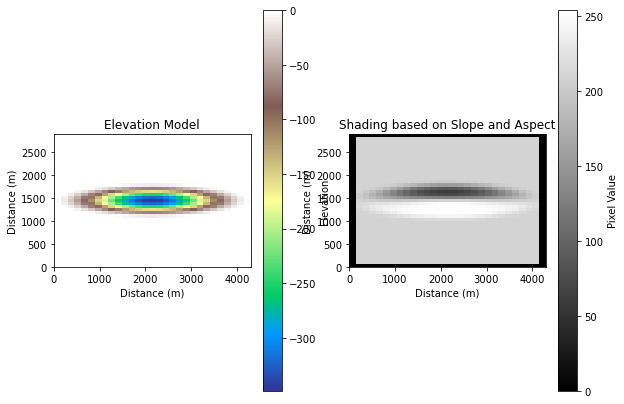

Image saved to RawPits/hole_mx43_my29_slope16_el56_az181_xrad564_yrad1473.pgm
Label image saved to RawLabels/hole_mx43_my29_slope16_el56_az181_xrad564_yrad1473.pgm


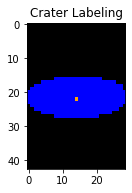

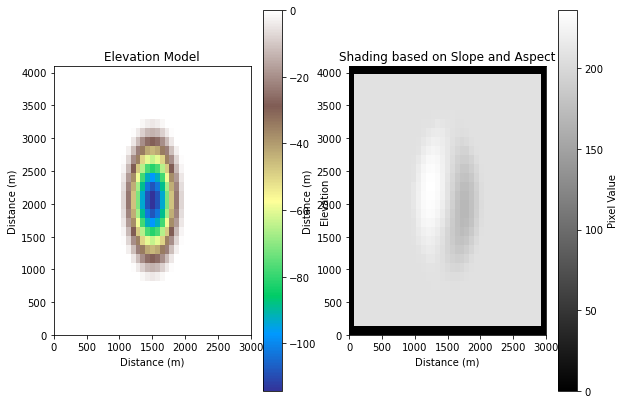

Image saved to RawPits/hole_mx30_my41_slope41_el55_az72_xrad966_yrad716.pgm
Label image saved to RawLabels/hole_mx30_my41_slope41_el55_az72_xrad966_yrad716.pgm


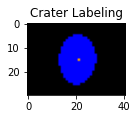

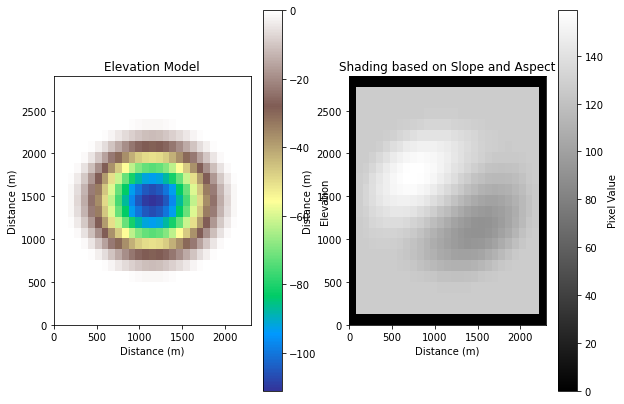

Image saved to RawPits/hole_mx23_my29_slope42_el30_az60_xrad758_yrad1303.pgm
Label image saved to RawLabels/hole_mx23_my29_slope42_el30_az60_xrad758_yrad1303.pgm


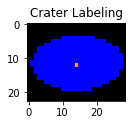

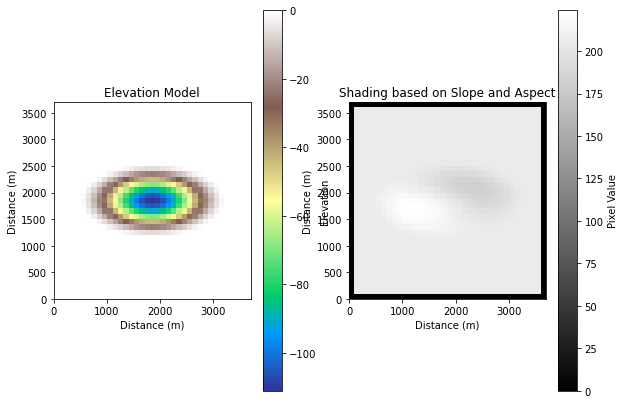

Image saved to RawPits/hole_mx37_my37_slope42_el54_az111_xrad709_yrad1408.pgm
Label image saved to RawLabels/hole_mx37_my37_slope42_el54_az111_xrad709_yrad1408.pgm


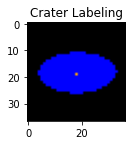

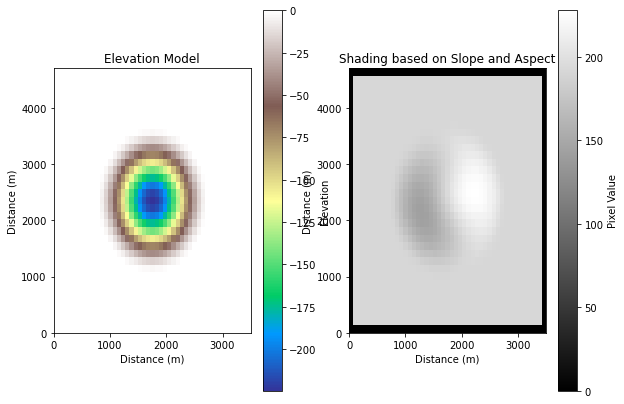

Image saved to RawPits/hole_mx35_my47_slope24_el49_az282_xrad967_yrad1331.pgm
Label image saved to RawLabels/hole_mx35_my47_slope24_el49_az282_xrad967_yrad1331.pgm


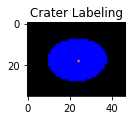

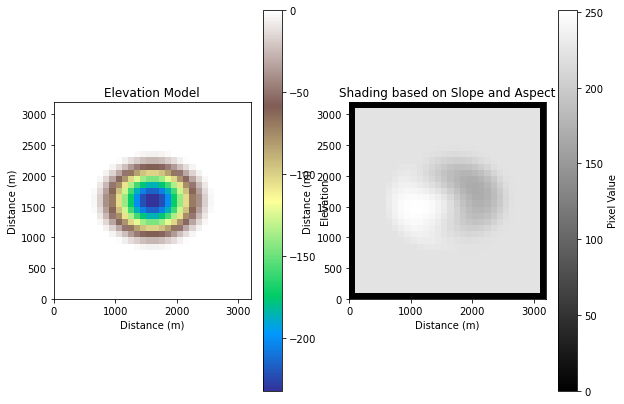

Image saved to RawPits/hole_mx32_my32_slope23_el61_az108_xrad828_yrad1029.pgm
Label image saved to RawLabels/hole_mx32_my32_slope23_el61_az108_xrad828_yrad1029.pgm


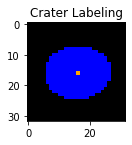

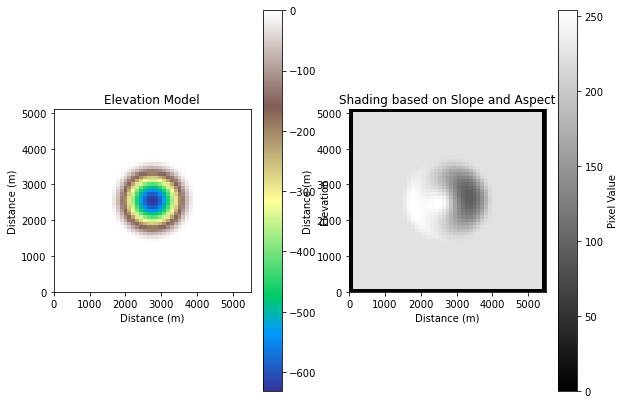

Image saved to RawPits/hole_mx55_my51_slope9_el62_az103_xrad1279_yrad1141.pgm
Label image saved to RawLabels/hole_mx55_my51_slope9_el62_az103_xrad1279_yrad1141.pgm


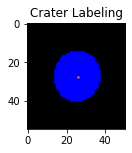

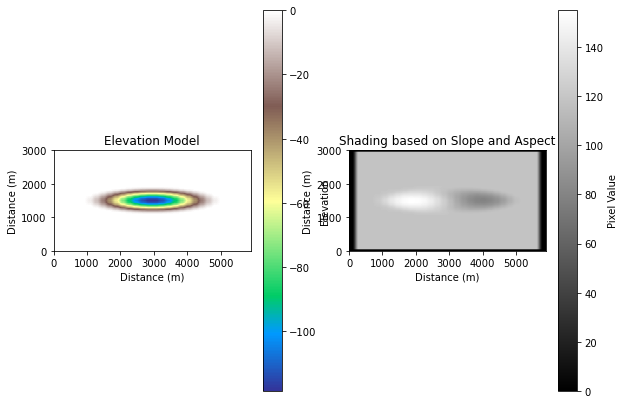

Image saved to RawPits/hole_mx59_my30_slope40_el28_az93_xrad819_yrad1064.pgm
Label image saved to RawLabels/hole_mx59_my30_slope40_el28_az93_xrad819_yrad1064.pgm


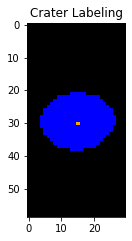

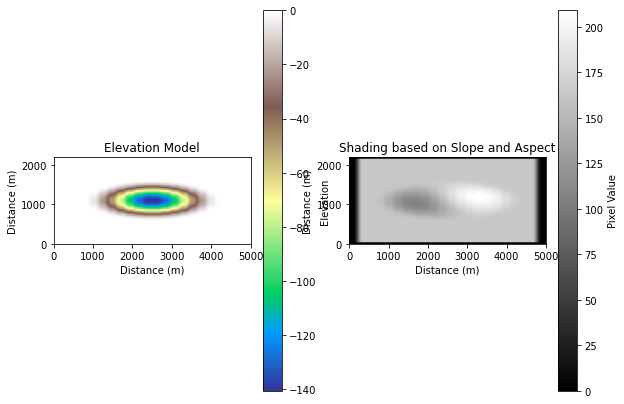

Image saved to RawPits/hole_mx50_my22_slope35_el40_az294_xrad1177_yrad744.pgm
Label image saved to RawLabels/hole_mx50_my22_slope35_el40_az294_xrad1177_yrad744.pgm


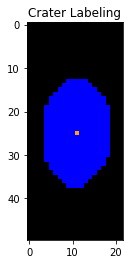

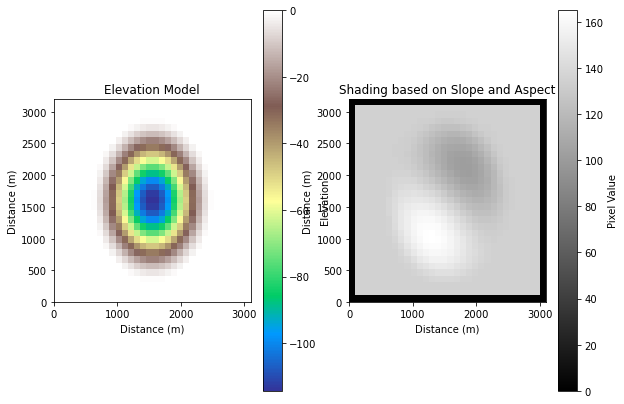

Image saved to RawPits/hole_mx31_my32_slope41_el32_az153_xrad1266_yrad1002.pgm
Label image saved to RawLabels/hole_mx31_my32_slope41_el32_az153_xrad1266_yrad1002.pgm


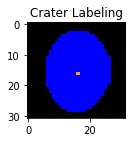

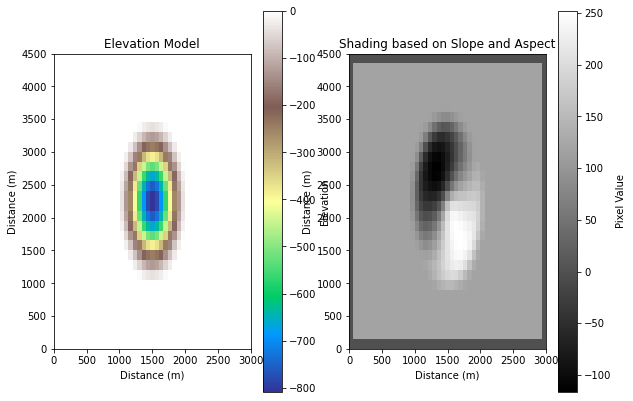

Image saved to RawPits/hole_mx30_my45_slope7_el28_az219_xrad873_yrad811.pgm
Label image saved to RawLabels/hole_mx30_my45_slope7_el28_az219_xrad873_yrad811.pgm


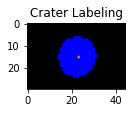

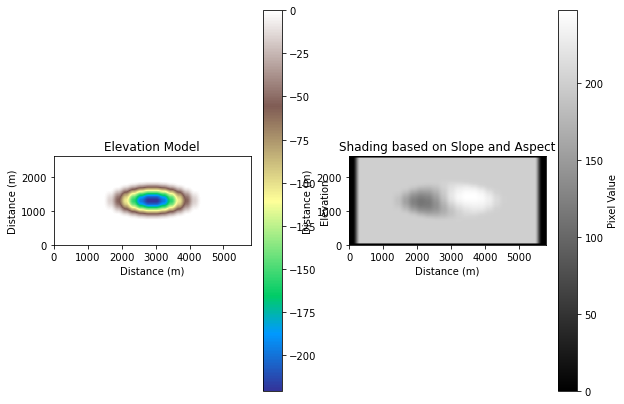

Image saved to RawPits/hole_mx58_my26_slope24_el52_az293_xrad1317_yrad667.pgm
Label image saved to RawLabels/hole_mx58_my26_slope24_el52_az293_xrad1317_yrad667.pgm


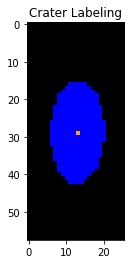

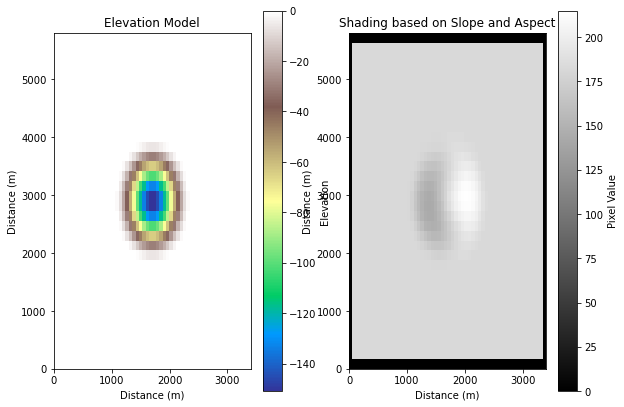

Image saved to RawPits/hole_mx34_my58_slope33_el46_az275_xrad634_yrad1119.pgm
Label image saved to RawLabels/hole_mx34_my58_slope33_el46_az275_xrad634_yrad1119.pgm


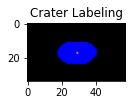

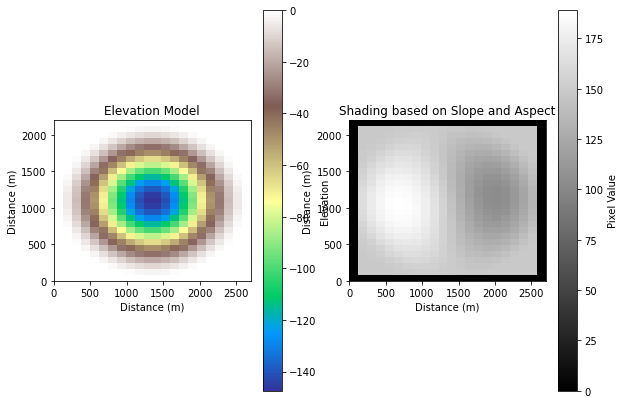

Image saved to RawPits/hole_mx27_my22_slope34_el36_az98_xrad1310_yrad1075.pgm
Label image saved to RawLabels/hole_mx27_my22_slope34_el36_az98_xrad1310_yrad1075.pgm


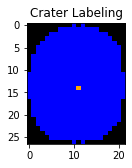

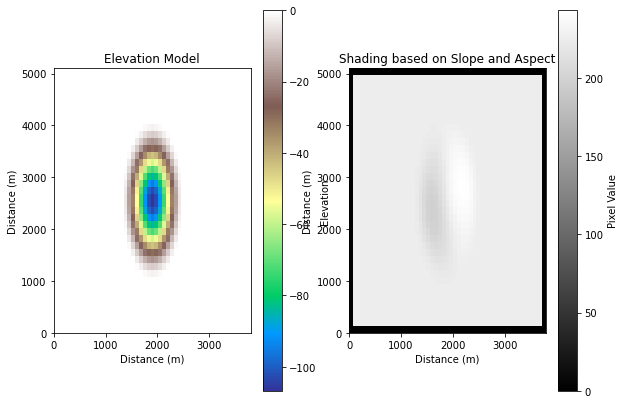

Image saved to RawPits/hole_mx38_my51_slope43_el62_az295_xrad1161_yrad802.pgm
Label image saved to RawLabels/hole_mx38_my51_slope43_el62_az295_xrad1161_yrad802.pgm


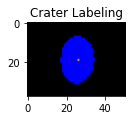

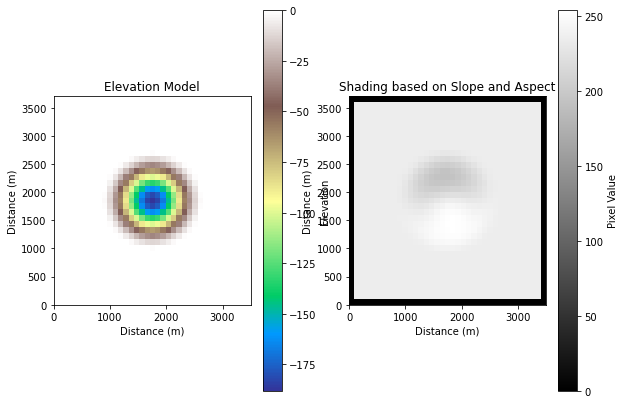

Image saved to RawPits/hole_mx35_my37_slope28_el68_az190_xrad836_yrad961.pgm
Label image saved to RawLabels/hole_mx35_my37_slope28_el68_az190_xrad836_yrad961.pgm


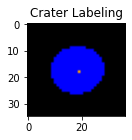

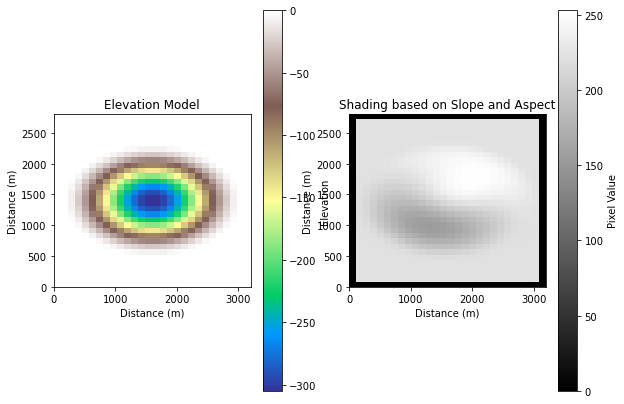

Image saved to RawPits/hole_mx32_my28_slope18_el61_az329_xrad1052_yrad1284.pgm
Label image saved to RawLabels/hole_mx32_my28_slope18_el61_az329_xrad1052_yrad1284.pgm


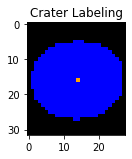

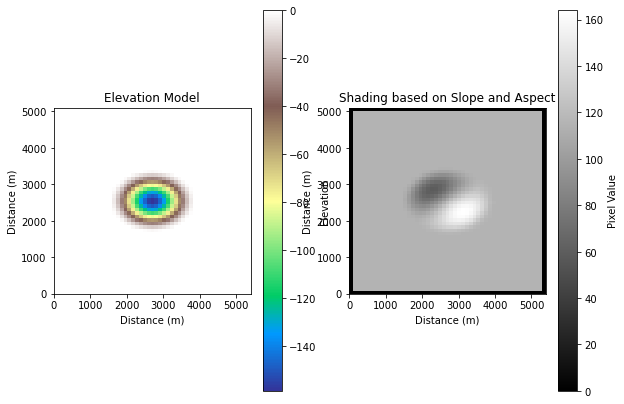

Image saved to RawPits/hole_mx54_my51_slope32_el27_az230_xrad916_yrad1136.pgm
Label image saved to RawLabels/hole_mx54_my51_slope32_el27_az230_xrad916_yrad1136.pgm


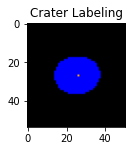

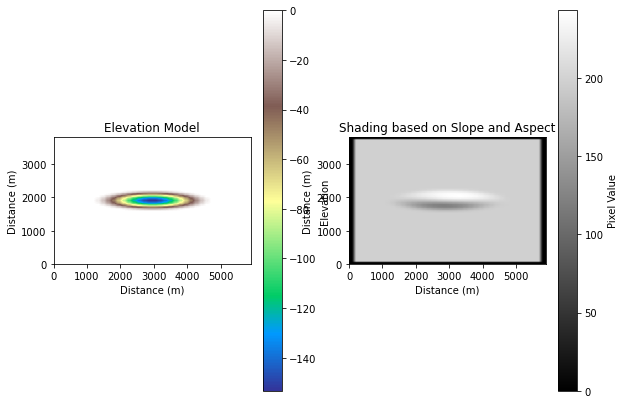

Image saved to RawPits/hole_mx59_my38_slope33_el51_az338_xrad500_yrad1179.pgm
Label image saved to RawLabels/hole_mx59_my38_slope33_el51_az338_xrad500_yrad1179.pgm


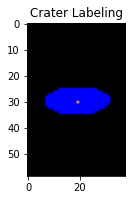

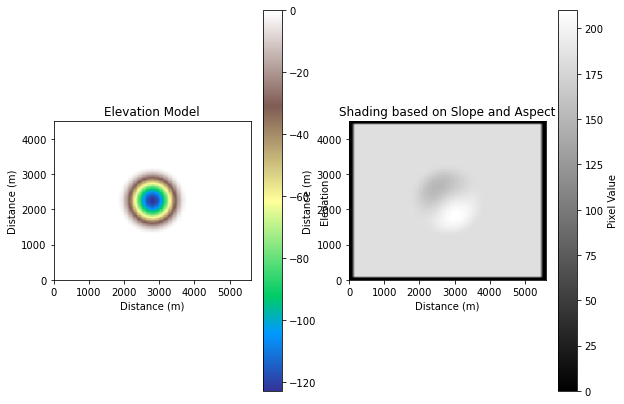

Image saved to RawPits/hole_mx56_my45_slope39_el46_az203_xrad1203_yrad788.pgm
Label image saved to RawLabels/hole_mx56_my45_slope39_el46_az203_xrad1203_yrad788.pgm


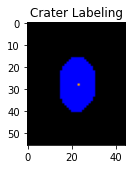

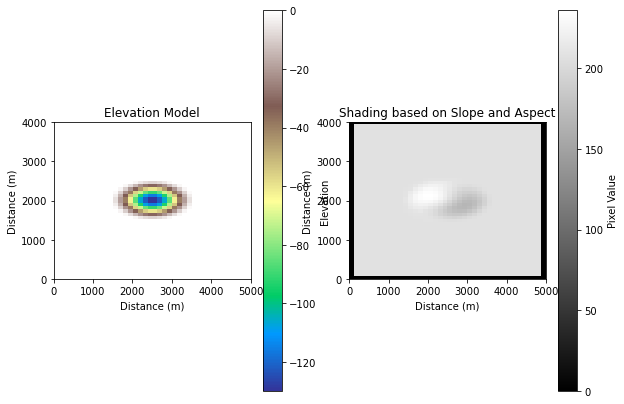

Image saved to RawPits/hole_mx50_my40_slope37_el55_az67_xrad662_yrad873.pgm
Label image saved to RawLabels/hole_mx50_my40_slope37_el55_az67_xrad662_yrad873.pgm


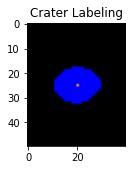

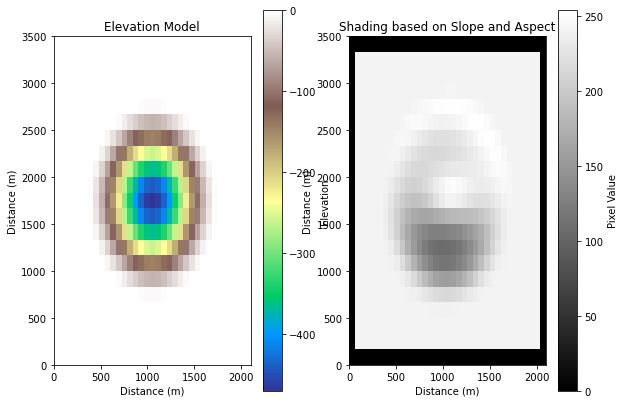

Image saved to RawPits/hole_mx21_my35_slope12_el72_az340_xrad642_yrad1165.pgm
Label image saved to RawLabels/hole_mx21_my35_slope12_el72_az340_xrad642_yrad1165.pgm


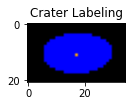

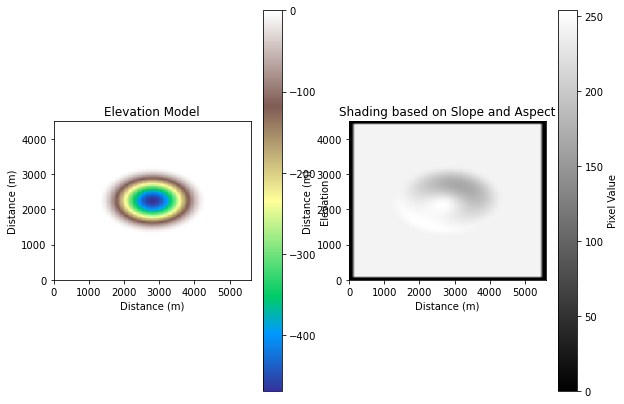

Image saved to RawPits/hole_mx56_my45_slope12_el72_az146_xrad1179_yrad1237.pgm
Label image saved to RawLabels/hole_mx56_my45_slope12_el72_az146_xrad1179_yrad1237.pgm


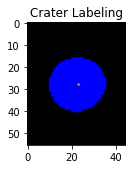

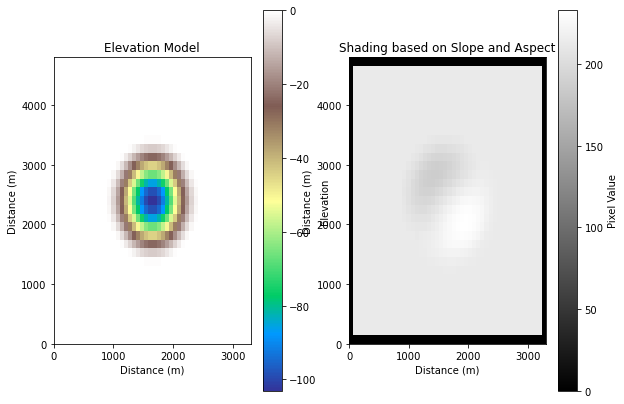

Image saved to RawPits/hole_mx33_my48_slope44_el57_az233_xrad736_yrad1141.pgm
Label image saved to RawLabels/hole_mx33_my48_slope44_el57_az233_xrad736_yrad1141.pgm


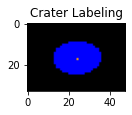

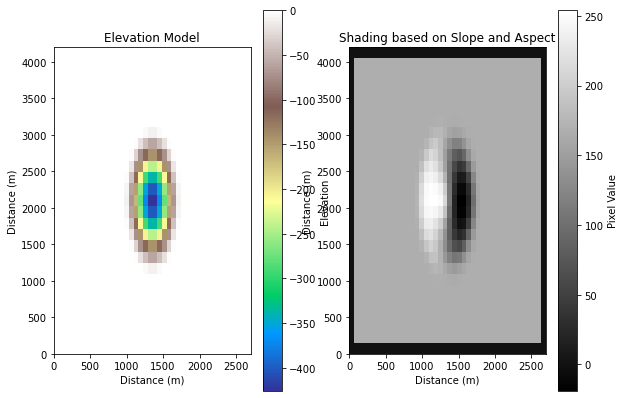

Image saved to RawPits/hole_mx27_my42_slope13_el41_az86_xrad661_yrad608.pgm
Label image saved to RawLabels/hole_mx27_my42_slope13_el41_az86_xrad661_yrad608.pgm


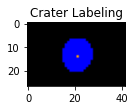

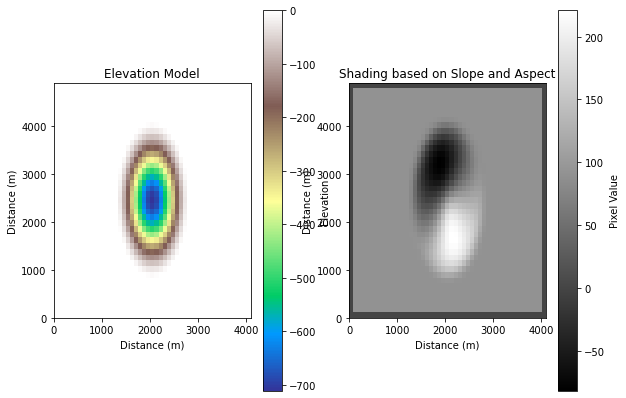

Image saved to RawPits/hole_mx41_my49_slope8_el21_az200_xrad1378_yrad911.pgm
Label image saved to RawLabels/hole_mx41_my49_slope8_el21_az200_xrad1378_yrad911.pgm


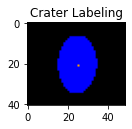

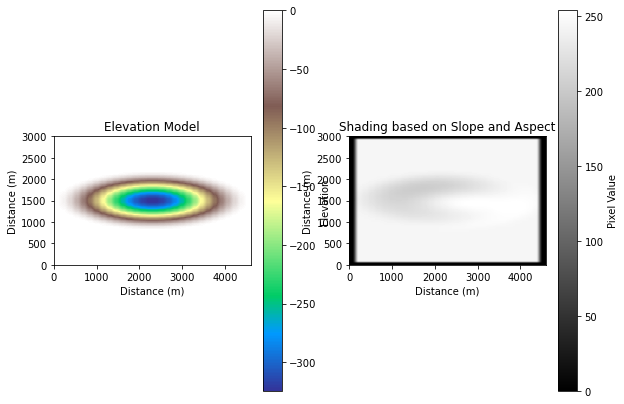

Image saved to RawPits/hole_mx46_my30_slope17_el74_az246_xrad1060_yrad1489.pgm
Label image saved to RawLabels/hole_mx46_my30_slope17_el74_az246_xrad1060_yrad1489.pgm


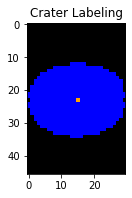

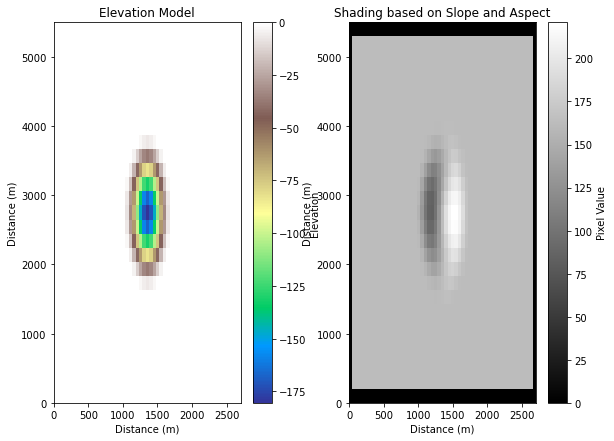

Image saved to RawPits/hole_mx27_my55_slope29_el40_az265_xrad571_yrad696.pgm
Label image saved to RawLabels/hole_mx27_my55_slope29_el40_az265_xrad571_yrad696.pgm


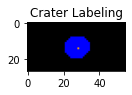

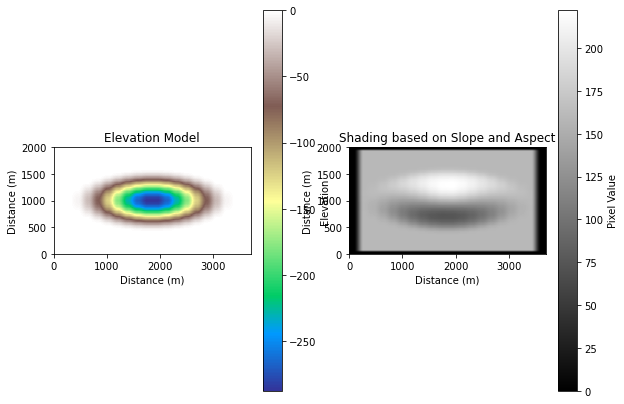

Image saved to RawPits/hole_mx37_my20_slope19_el39_az358_xrad1087_yrad823.pgm
Label image saved to RawLabels/hole_mx37_my20_slope19_el39_az358_xrad1087_yrad823.pgm


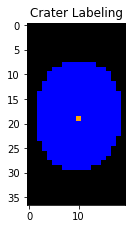

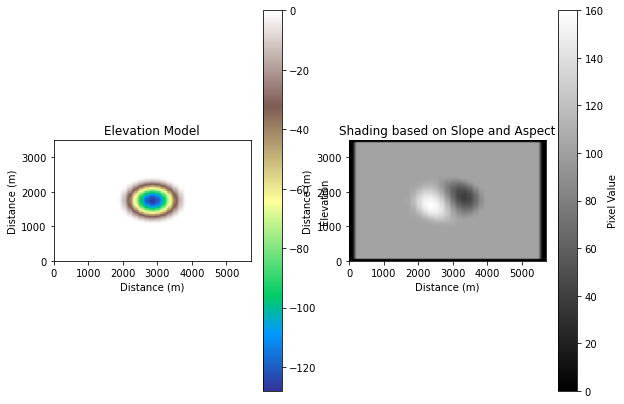

Image saved to RawPits/hole_mx57_my35_slope38_el24_az123_xrad1151_yrad632.pgm
Label image saved to RawLabels/hole_mx57_my35_slope38_el24_az123_xrad1151_yrad632.pgm


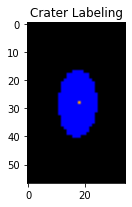

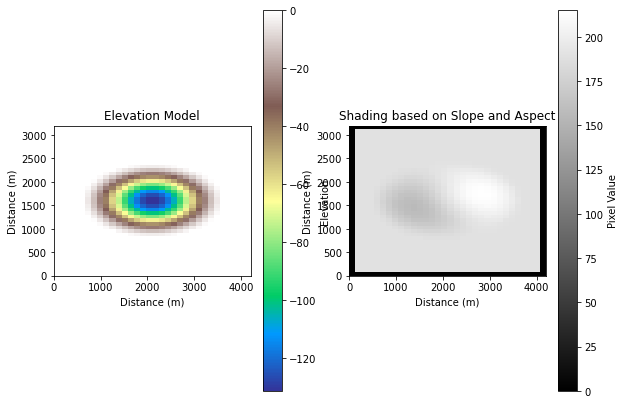

Image saved to RawPits/hole_mx42_my32_slope37_el48_az289_xrad1070_yrad1197.pgm
Label image saved to RawLabels/hole_mx42_my32_slope37_el48_az289_xrad1070_yrad1197.pgm


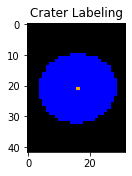

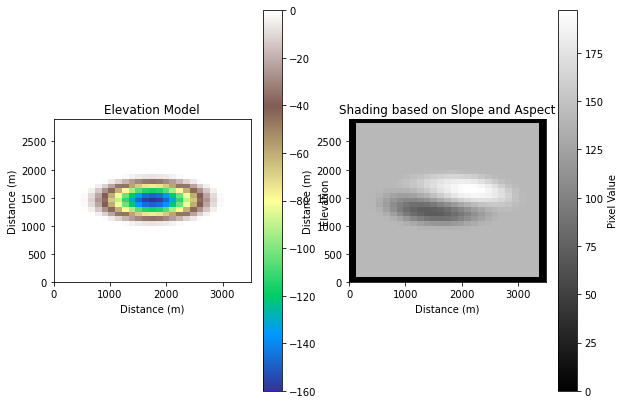

Image saved to RawPits/hole_mx35_my29_slope32_el34_az312_xrad578_yrad1085.pgm
Label image saved to RawLabels/hole_mx35_my29_slope32_el34_az312_xrad578_yrad1085.pgm


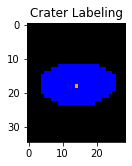

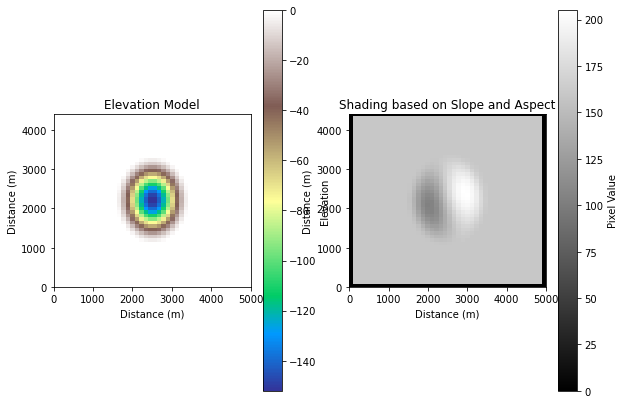

Image saved to RawPits/hole_mx50_my44_slope33_el39_az294_xrad1289_yrad839.pgm
Label image saved to RawLabels/hole_mx50_my44_slope33_el39_az294_xrad1289_yrad839.pgm


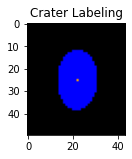

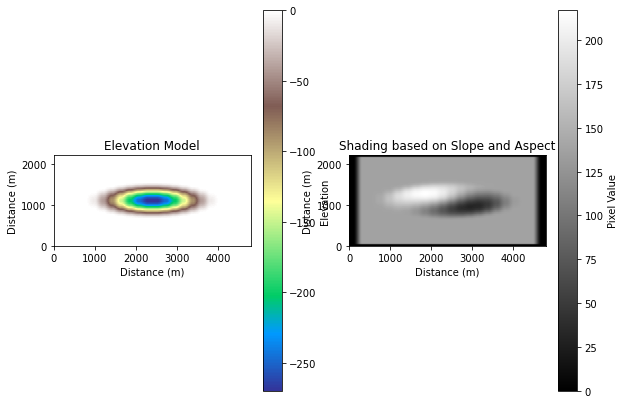

Image saved to RawPits/hole_mx48_my22_slope20_el33_az40_xrad979_yrad736.pgm
Label image saved to RawLabels/hole_mx48_my22_slope20_el33_az40_xrad979_yrad736.pgm


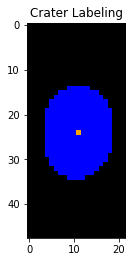

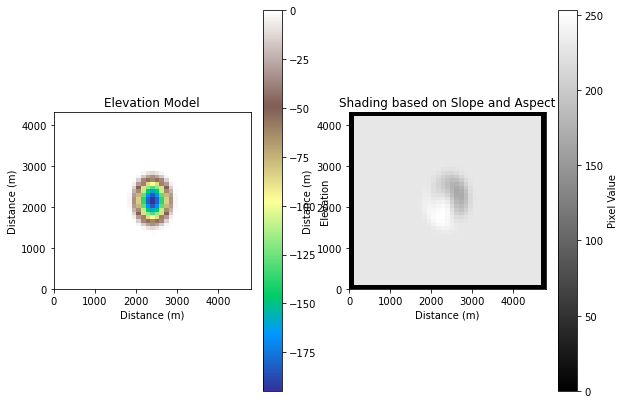

Image saved to RawPits/hole_mx48_my43_slope27_el64_az145_xrad888_yrad549.pgm
Label image saved to RawLabels/hole_mx48_my43_slope27_el64_az145_xrad888_yrad549.pgm


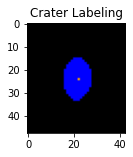

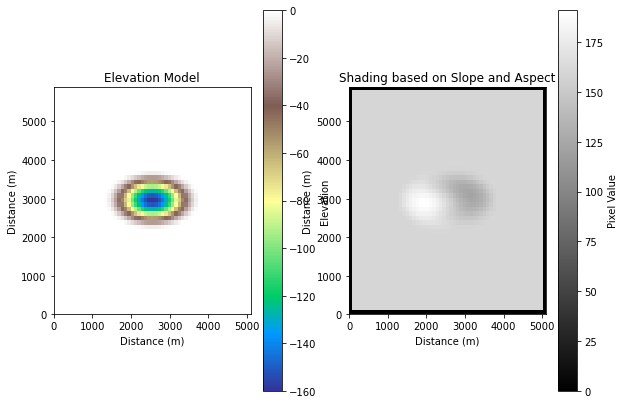

Image saved to RawPits/hole_mx51_my59_slope32_el39_az98_xrad674_yrad1460.pgm
Label image saved to RawLabels/hole_mx51_my59_slope32_el39_az98_xrad674_yrad1460.pgm


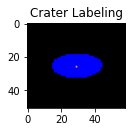

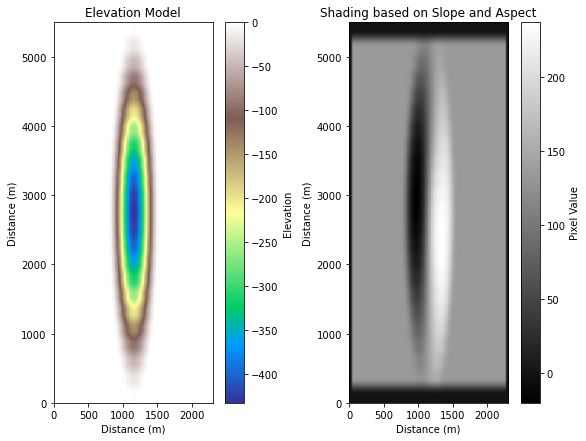

Image saved to RawPits/hole_mx23_my55_slope13_el32_az256_xrad1154_yrad872.pgm
Label image saved to RawLabels/hole_mx23_my55_slope13_el32_az256_xrad1154_yrad872.pgm


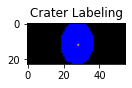

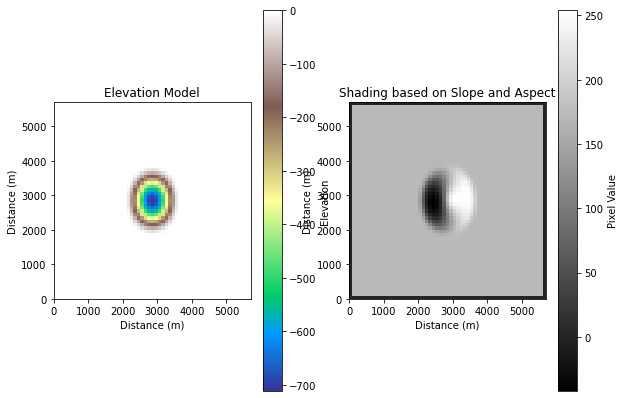

Image saved to RawPits/hole_mx57_my57_slope8_el43_az278_xrad1046_yrad818.pgm
Label image saved to RawLabels/hole_mx57_my57_slope8_el43_az278_xrad1046_yrad818.pgm


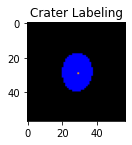

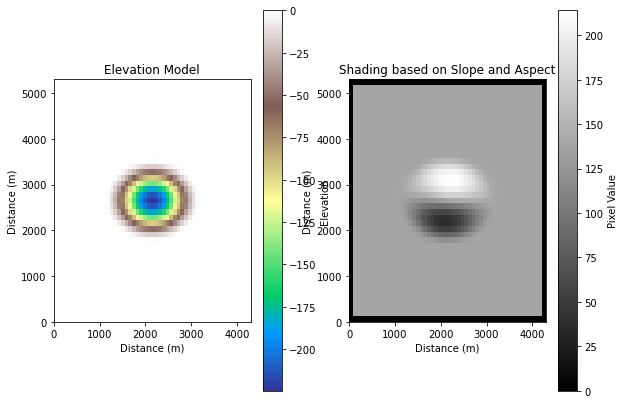

Image saved to RawPits/hole_mx43_my53_slope24_el33_az349_xrad732_yrad1289.pgm
Label image saved to RawLabels/hole_mx43_my53_slope24_el33_az349_xrad732_yrad1289.pgm


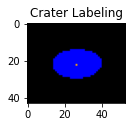

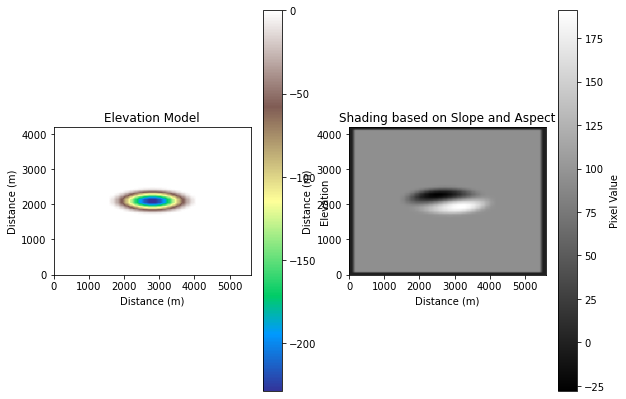

Image saved to RawPits/hole_mx56_my42_slope23_el22_az222_xrad511_yrad981.pgm
Label image saved to RawLabels/hole_mx56_my42_slope23_el22_az222_xrad511_yrad981.pgm


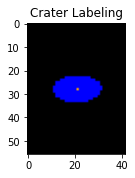

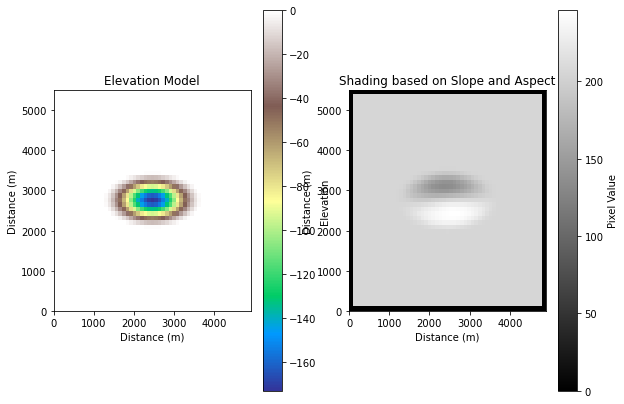

Image saved to RawPits/hole_mx49_my55_slope30_el54_az195_xrad632_yrad1399.pgm
Label image saved to RawLabels/hole_mx49_my55_slope30_el54_az195_xrad632_yrad1399.pgm


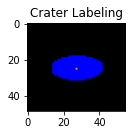

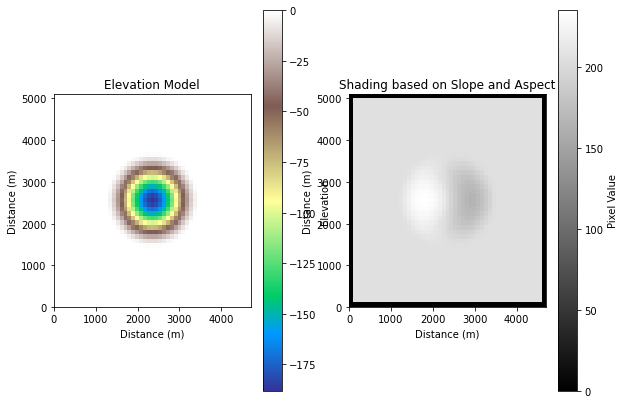

Image saved to RawPits/hole_mx47_my51_slope28_el54_az90_xrad1059_yrad1221.pgm
Label image saved to RawLabels/hole_mx47_my51_slope28_el54_az90_xrad1059_yrad1221.pgm


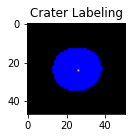

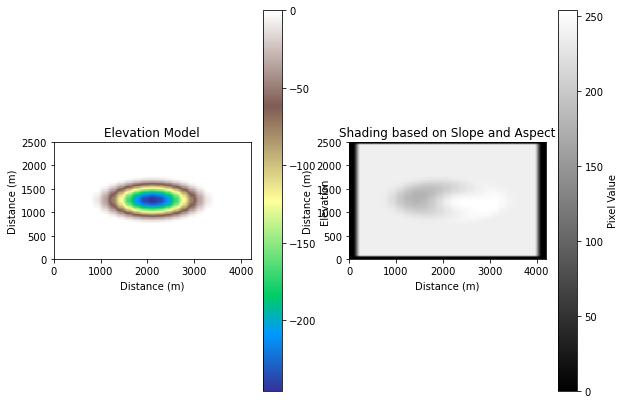

Image saved to RawPits/hole_mx42_my25_slope22_el69_az251_xrad856_yrad795.pgm
Label image saved to RawLabels/hole_mx42_my25_slope22_el69_az251_xrad856_yrad795.pgm


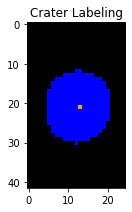

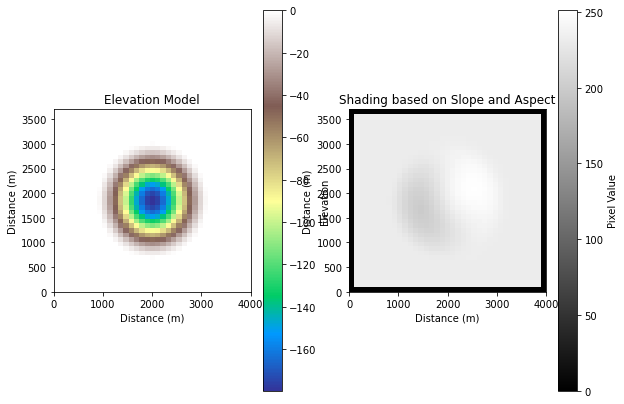

Image saved to RawPits/hole_mx40_my37_slope29_el66_az296_xrad1306_yrad1076.pgm
Label image saved to RawLabels/hole_mx40_my37_slope29_el66_az296_xrad1306_yrad1076.pgm


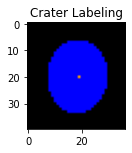

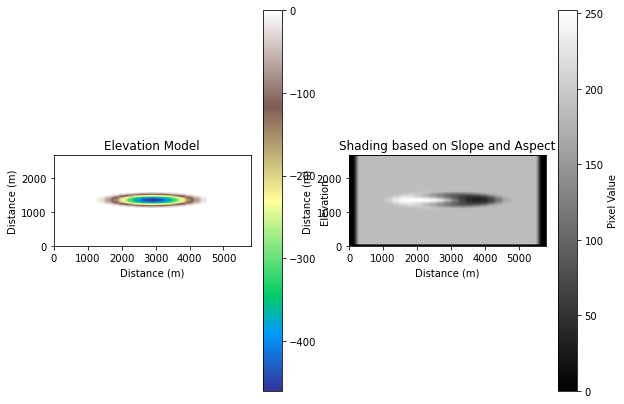

Image saved to RawPits/hole_mx58_my27_slope12_el47_az93_xrad541_yrad817.pgm
Label image saved to RawLabels/hole_mx58_my27_slope12_el47_az93_xrad541_yrad817.pgm


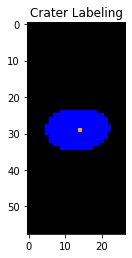

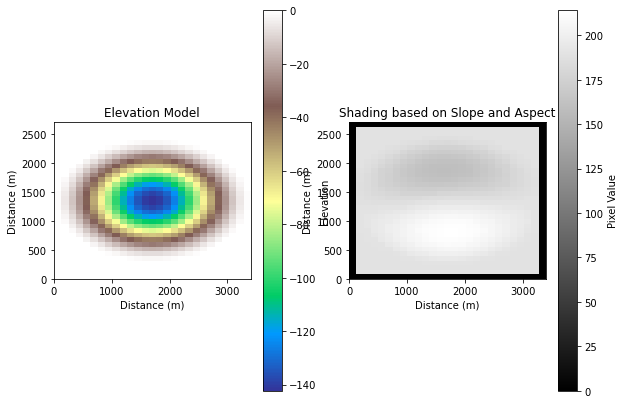

Image saved to RawPits/hole_mx34_my27_slope35_el48_az184_xrad1352_yrad1367.pgm
Label image saved to RawLabels/hole_mx34_my27_slope35_el48_az184_xrad1352_yrad1367.pgm


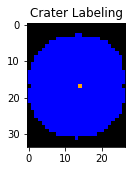

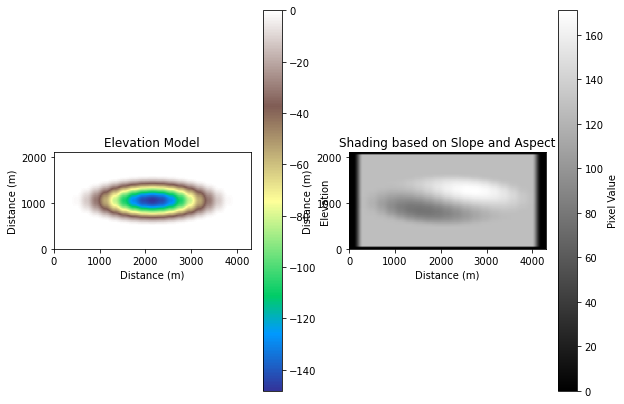

Image saved to RawPits/hole_mx43_my21_slope34_el30_az328_xrad1138_yrad860.pgm
Label image saved to RawLabels/hole_mx43_my21_slope34_el30_az328_xrad1138_yrad860.pgm


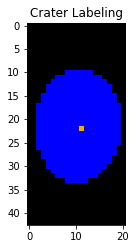

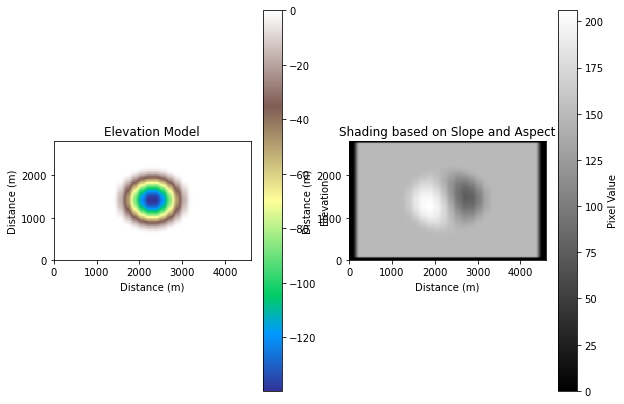

Image saved to RawPits/hole_mx46_my28_slope35_el36_az117_xrad1316_yrad577.pgm
Label image saved to RawLabels/hole_mx46_my28_slope35_el36_az117_xrad1316_yrad577.pgm


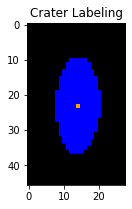

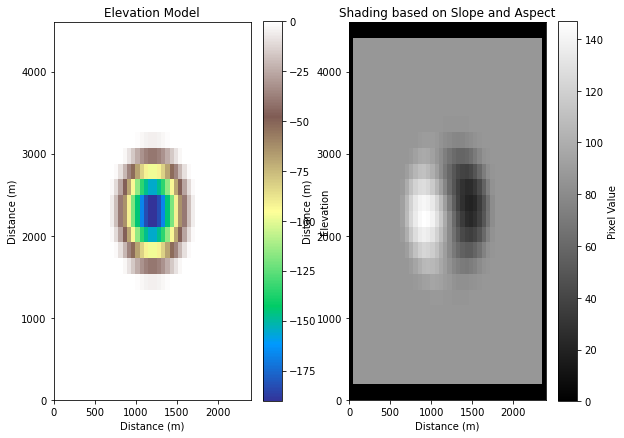

Image saved to RawPits/hole_mx24_my46_slope27_el20_az95_xrad500_yrad1072.pgm
Label image saved to RawLabels/hole_mx24_my46_slope27_el20_az95_xrad500_yrad1072.pgm


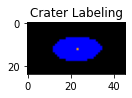

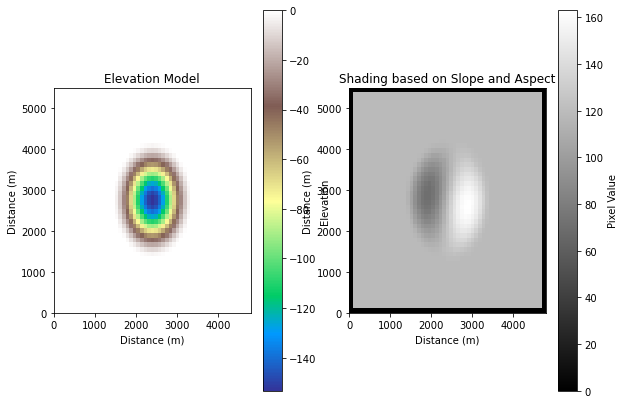

Image saved to RawPits/hole_mx48_my55_slope33_el28_az258_xrad1251_yrad1117.pgm
Label image saved to RawLabels/hole_mx48_my55_slope33_el28_az258_xrad1251_yrad1117.pgm


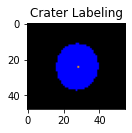

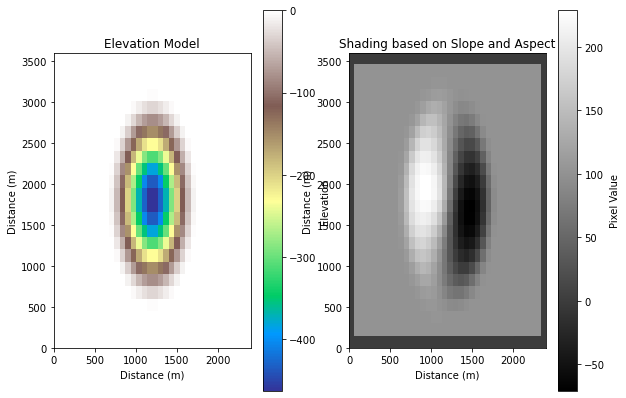

Image saved to RawPits/hole_mx24_my36_slope12_el24_az78_xrad895_yrad826.pgm
Label image saved to RawLabels/hole_mx24_my36_slope12_el24_az78_xrad895_yrad826.pgm


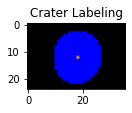

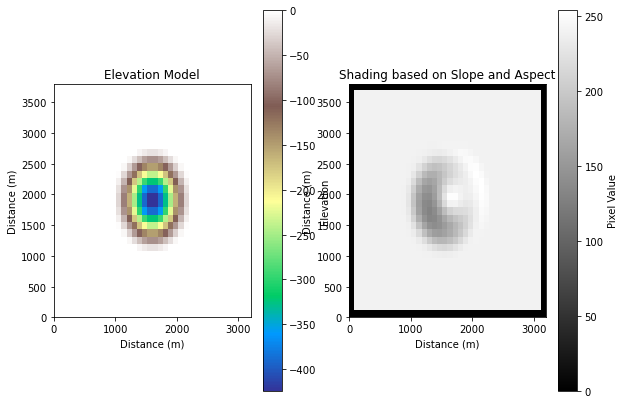

Image saved to RawPits/hole_mx32_my38_slope13_el71_az293_xrad755_yrad778.pgm
Label image saved to RawLabels/hole_mx32_my38_slope13_el71_az293_xrad755_yrad778.pgm


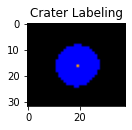

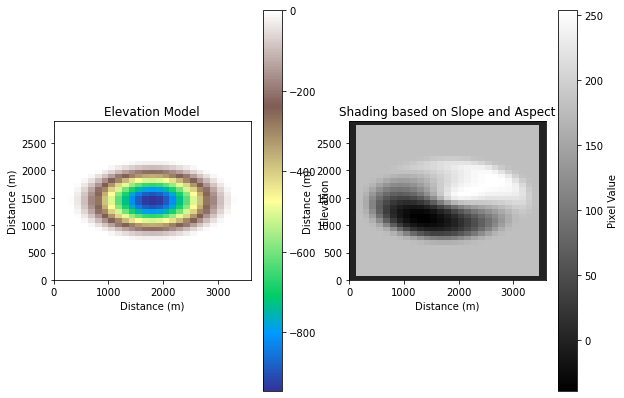

Image saved to RawPits/hole_mx36_my29_slope6_el45_az318_xrad948_yrad1257.pgm
Label image saved to RawLabels/hole_mx36_my29_slope6_el45_az318_xrad948_yrad1257.pgm


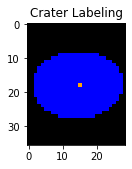

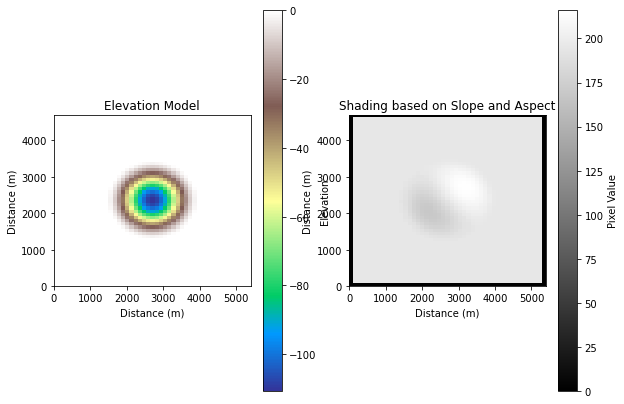

Image saved to RawPits/hole_mx54_my47_slope42_el50_az313_xrad1268_yrad1101.pgm
Label image saved to RawLabels/hole_mx54_my47_slope42_el50_az313_xrad1268_yrad1101.pgm


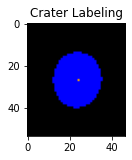

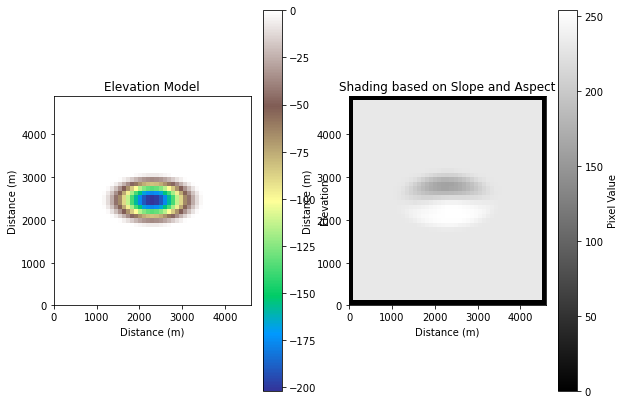

Image saved to RawPits/hole_mx46_my49_slope26_el65_az189_xrad622_yrad1303.pgm
Label image saved to RawLabels/hole_mx46_my49_slope26_el65_az189_xrad622_yrad1303.pgm


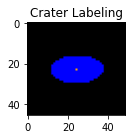

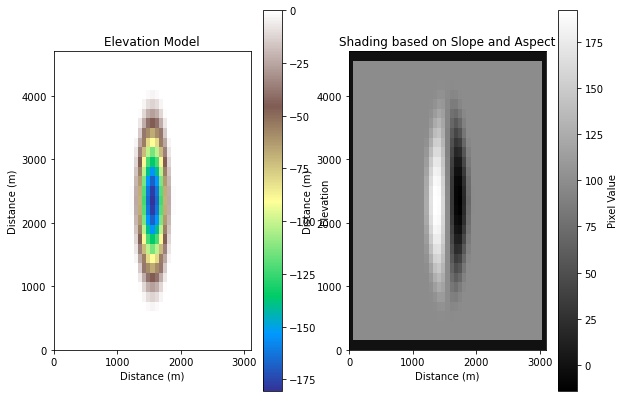

Image saved to RawPits/hole_mx31_my47_slope29_el23_az94_xrad1201_yrad523.pgm
Label image saved to RawLabels/hole_mx31_my47_slope29_el23_az94_xrad1201_yrad523.pgm


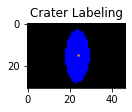

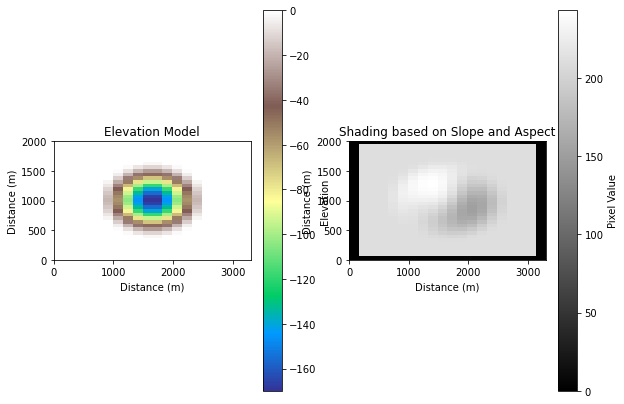

Image saved to RawPits/hole_mx33_my20_slope30_el56_az37_xrad1082_yrad572.pgm
Label image saved to RawLabels/hole_mx33_my20_slope30_el56_az37_xrad1082_yrad572.pgm


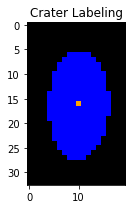

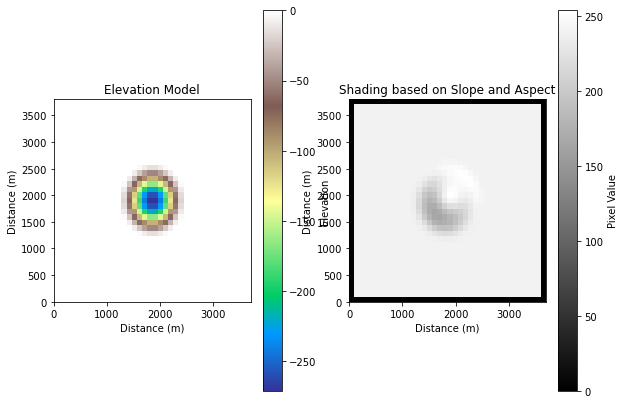

Image saved to RawPits/hole_mx37_my38_slope20_el71_az323_xrad699_yrad659.pgm
Label image saved to RawLabels/hole_mx37_my38_slope20_el71_az323_xrad699_yrad659.pgm


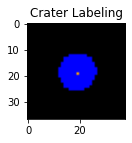

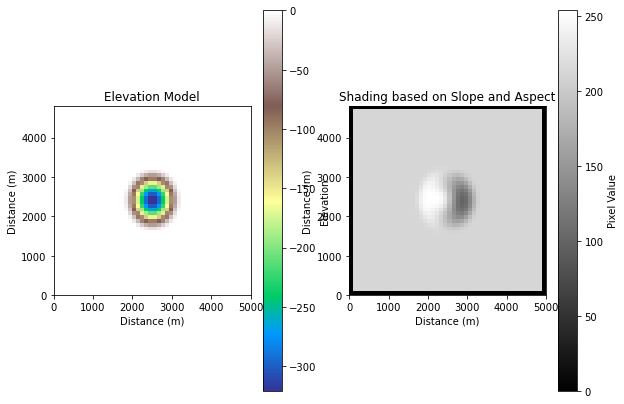

Image saved to RawPits/hole_mx50_my48_slope17_el57_az85_xrad873_yrad736.pgm
Label image saved to RawLabels/hole_mx50_my48_slope17_el57_az85_xrad873_yrad736.pgm


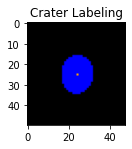

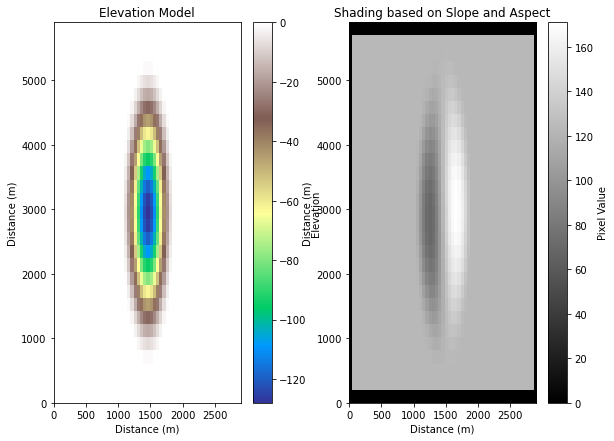

Image saved to RawPits/hole_mx29_my59_slope38_el29_az277_xrad1179_yrad819.pgm
Label image saved to RawLabels/hole_mx29_my59_slope38_el29_az277_xrad1179_yrad819.pgm


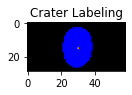

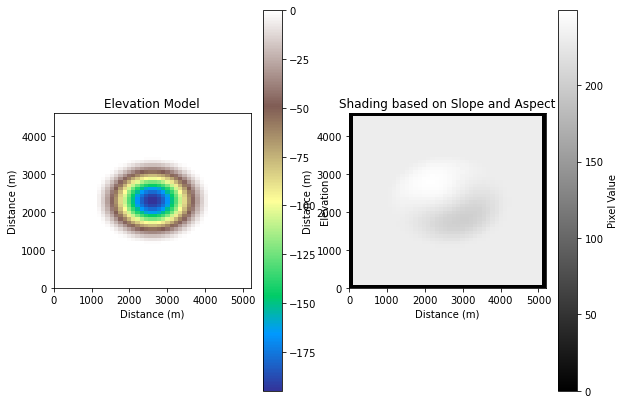

Image saved to RawPits/hole_mx52_my46_slope27_el65_az33_xrad1322_yrad1397.pgm
Label image saved to RawLabels/hole_mx52_my46_slope27_el65_az33_xrad1322_yrad1397.pgm


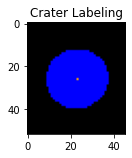

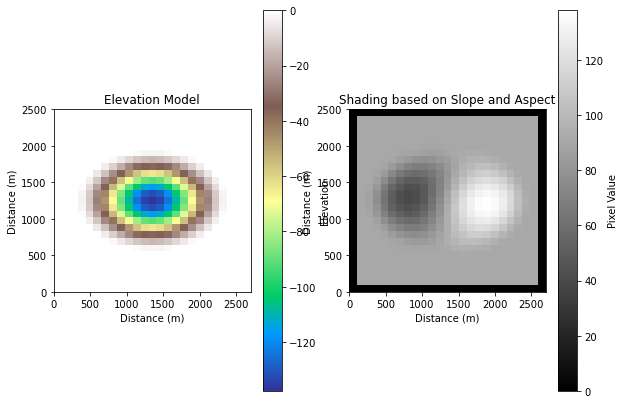

Image saved to RawPits/hole_mx27_my25_slope36_el21_az264_xrad766_yrad991.pgm
Label image saved to RawLabels/hole_mx27_my25_slope36_el21_az264_xrad766_yrad991.pgm


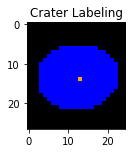

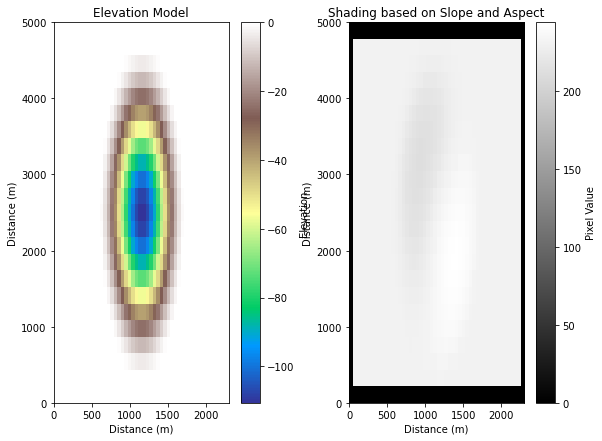

Image saved to RawPits/hole_mx23_my50_slope42_el65_az238_xrad1016_yrad1222.pgm
Label image saved to RawLabels/hole_mx23_my50_slope42_el65_az238_xrad1016_yrad1222.pgm


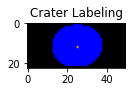

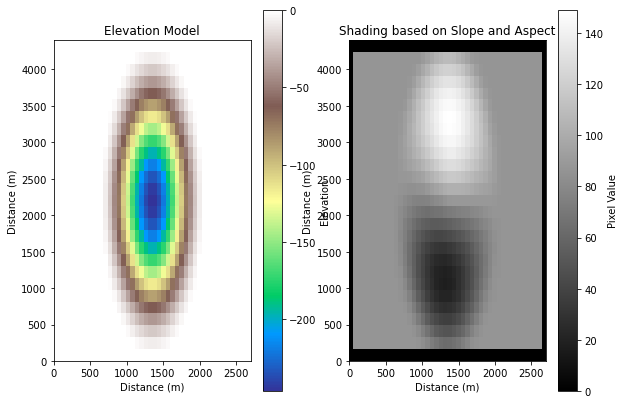

Image saved to RawPits/hole_mx27_my44_slope22_el20_az355_xrad1352_yrad1182.pgm
Label image saved to RawLabels/hole_mx27_my44_slope22_el20_az355_xrad1352_yrad1182.pgm


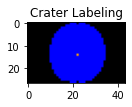

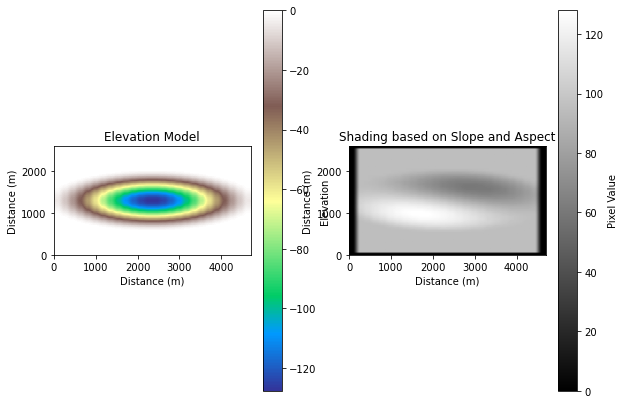

Image saved to RawPits/hole_mx47_my26_slope38_el22_az148_xrad1341_yrad1425.pgm
Label image saved to RawLabels/hole_mx47_my26_slope38_el22_az148_xrad1341_yrad1425.pgm


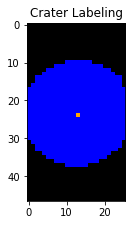

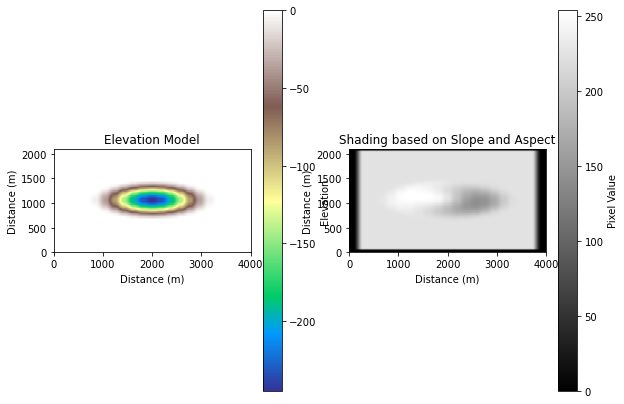

Image saved to RawPits/hole_mx40_my21_slope22_el62_az71_xrad780_yrad671.pgm
Label image saved to RawLabels/hole_mx40_my21_slope22_el62_az71_xrad780_yrad671.pgm


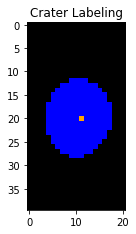

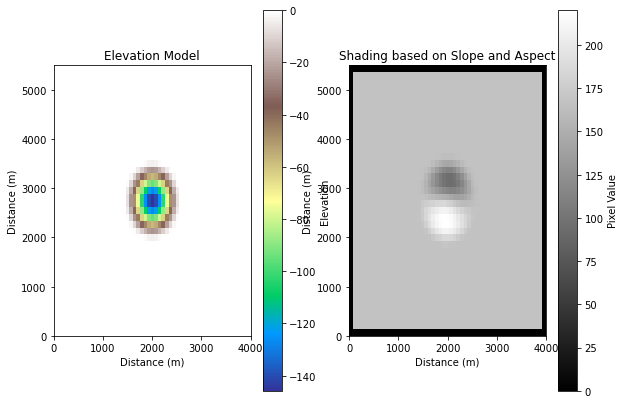

Image saved to RawPits/hole_mx40_my55_slope34_el41_az169_xrad611_yrad821.pgm
Label image saved to RawLabels/hole_mx40_my55_slope34_el41_az169_xrad611_yrad821.pgm


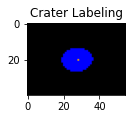

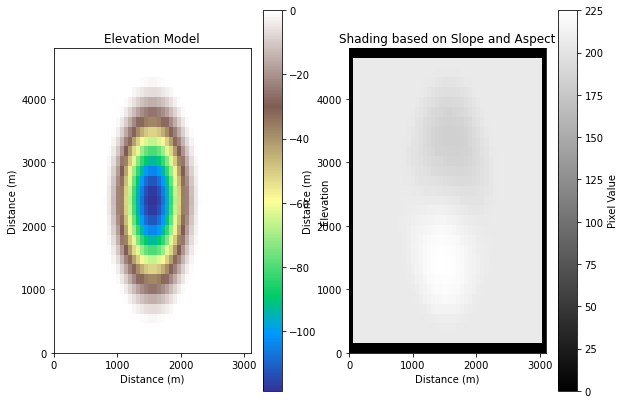

Image saved to RawPits/hole_mx31_my48_slope40_el54_az171_xrad1294_yrad1198.pgm
Label image saved to RawLabels/hole_mx31_my48_slope40_el54_az171_xrad1294_yrad1198.pgm


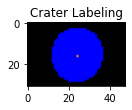

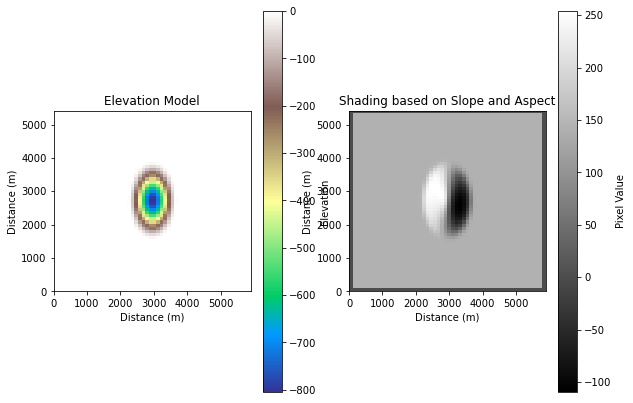

Image saved to RawPits/hole_mx59_my54_slope7_el34_az71_xrad1306_yrad682.pgm
Label image saved to RawLabels/hole_mx59_my54_slope7_el34_az71_xrad1306_yrad682.pgm


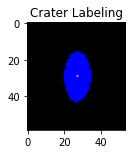

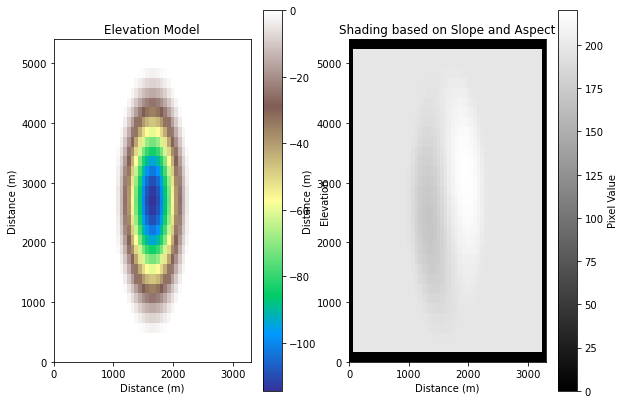

Image saved to RawPits/hole_mx33_my54_slope41_el51_az295_xrad1441_yrad1083.pgm
Label image saved to RawLabels/hole_mx33_my54_slope41_el51_az295_xrad1441_yrad1083.pgm


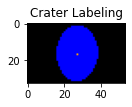

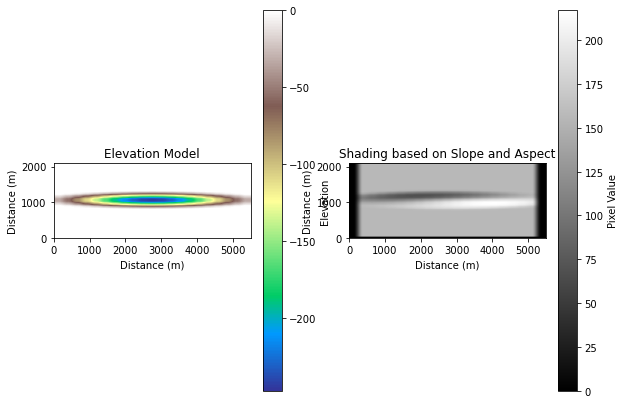

Image saved to RawPits/hole_mx55_my21_slope22_el38_az230_xrad696_yrad1314.pgm
Label image saved to RawLabels/hole_mx55_my21_slope22_el38_az230_xrad696_yrad1314.pgm


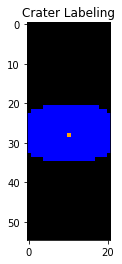

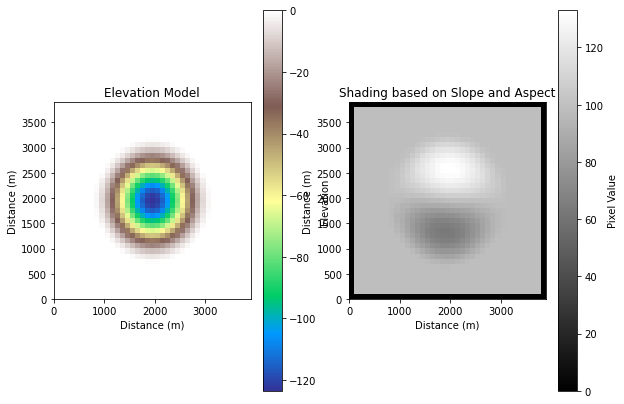

Image saved to RawPits/hole_mx39_my39_slope39_el23_az356_xrad1260_yrad1187.pgm
Label image saved to RawLabels/hole_mx39_my39_slope39_el23_az356_xrad1260_yrad1187.pgm


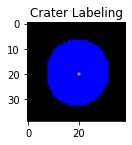

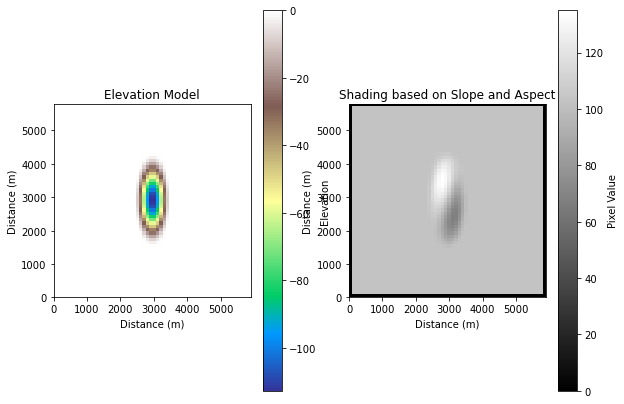

Image saved to RawPits/hole_mx59_my58_slope41_el24_az18_xrad1451_yrad546.pgm
Label image saved to RawLabels/hole_mx59_my58_slope41_el24_az18_xrad1451_yrad546.pgm


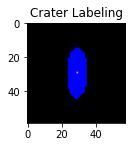

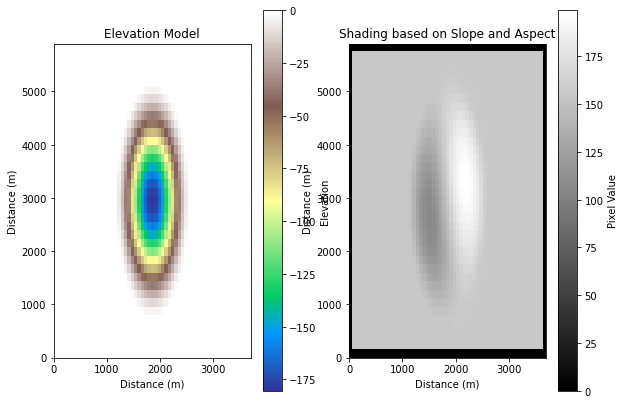

Image saved to RawPits/hole_mx37_my59_slope29_el38_az291_xrad1426_yrad1138.pgm
Label image saved to RawLabels/hole_mx37_my59_slope29_el38_az291_xrad1426_yrad1138.pgm


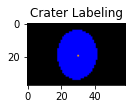

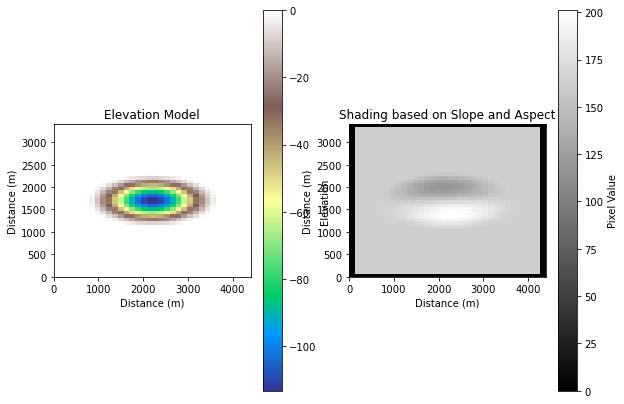

Image saved to RawPits/hole_mx44_my34_slope41_el40_az191_xrad786_yrad1178.pgm
Label image saved to RawLabels/hole_mx44_my34_slope41_el40_az191_xrad786_yrad1178.pgm


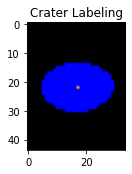

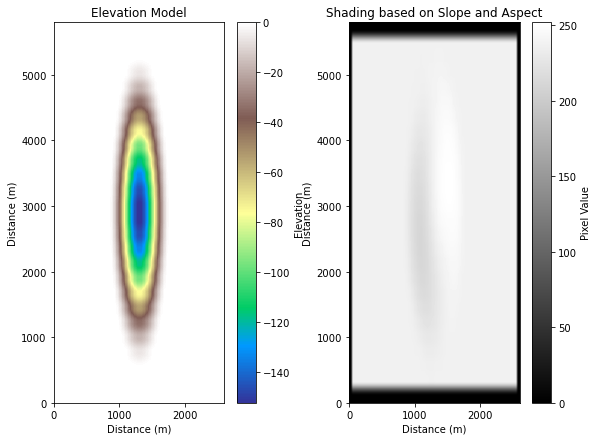

Image saved to RawPits/hole_mx26_my58_slope33_el69_az294_xrad1092_yrad1022.pgm
Label image saved to RawLabels/hole_mx26_my58_slope33_el69_az294_xrad1092_yrad1022.pgm


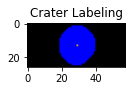

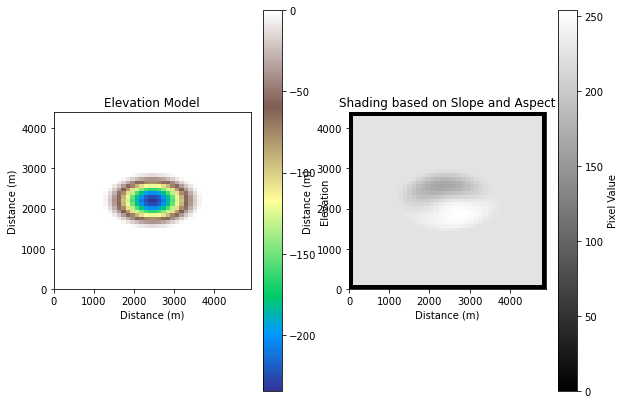

Image saved to RawPits/hole_mx49_my44_slope23_el63_az203_xrad821_yrad1160.pgm
Label image saved to RawLabels/hole_mx49_my44_slope23_el63_az203_xrad821_yrad1160.pgm


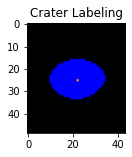

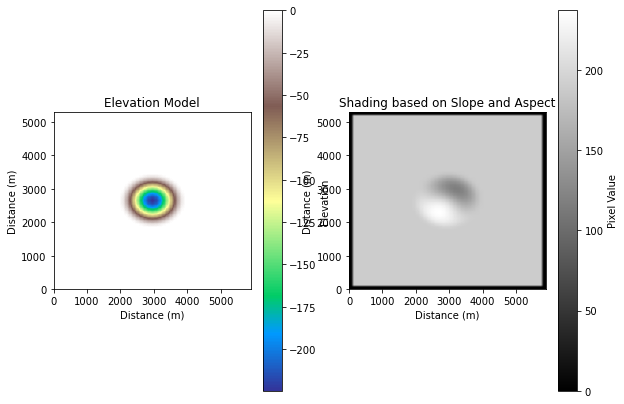

Image saved to RawPits/hole_mx59_my53_slope24_el48_az148_xrad915_yrad901.pgm
Label image saved to RawLabels/hole_mx59_my53_slope24_el48_az148_xrad915_yrad901.pgm


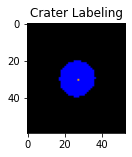

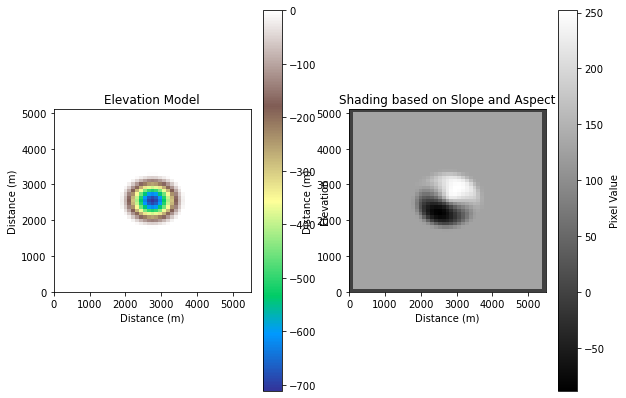

Image saved to RawPits/hole_mx55_my51_slope8_el31_az329_xrad847_yrad893.pgm
Label image saved to RawLabels/hole_mx55_my51_slope8_el31_az329_xrad847_yrad893.pgm


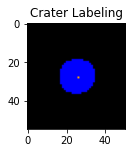

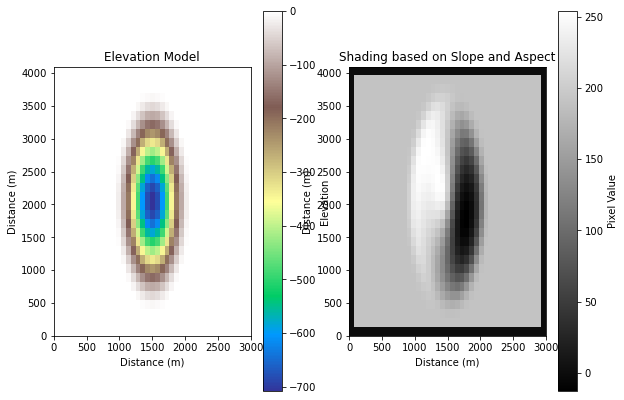

Image saved to RawPits/hole_mx30_my41_slope8_el49_az64_xrad1245_yrad787.pgm
Label image saved to RawLabels/hole_mx30_my41_slope8_el49_az64_xrad1245_yrad787.pgm


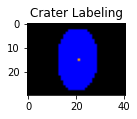

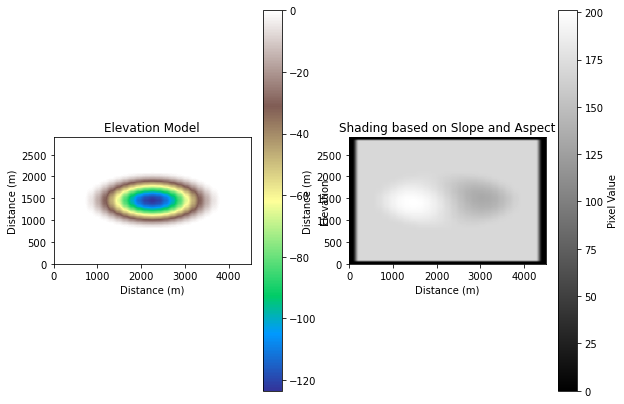

Image saved to RawPits/hole_mx45_my29_slope39_el42_az99_xrad1038_yrad1040.pgm
Label image saved to RawLabels/hole_mx45_my29_slope39_el42_az99_xrad1038_yrad1040.pgm


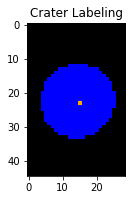

In [15]:
for i in range(0,400):
    mx_rand = 20 + int(random.random() * 40)
    my_rand = 20 + int(random.random() * 40)
    slope_rand = 5 + int(random.random() * 40)
    az_rand = int(random.random() * 360)
    elev_rand = 20 + int(random.random() * 55)
    xrad_rand = 500 + int(random.random() * 1000)
    yrad_rand = 500 + int(random.random() * 1000)
    make_hole(mx = mx_rand, my = my_rand, max_slope_deg = slope_rand, sun_elevation_deg = elev_rand,
              sun_azimuth_deg = az_rand,radius_x = xrad_rand, radius_y = yrad_rand,
              data_dir='RawPits', label_dir = 'RawLabels')